# 03 - Exploratory Data Analysis: Skill Demand Insights

This notebook analyzes skill demand patterns across all job datasets to uncover:
- Most in-demand skills overall and by industry
- Temporal trends and emerging skills
- Skill co-occurrence patterns
- Geographic and salary correlations

**Inputs:** Processed parquet files from Notebooks 01 & 02

**Outputs:** Visualizations saved as PNG to `ml/notebook/figures/`

## 3.1 Setup & Load Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from collections import Counter
from itertools import combinations
from pathlib import Path
import networkx as nx
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

PROCESS_DIR = Path('../data/process')
FIG_DIR = Path('figures')
FIG_DIR.mkdir(exist_ok=True)

# Load data
df_mapping = pd.read_parquet(PROCESS_DIR / 'job_skill_mapping.parquet')
df_taxonomy = pd.read_parquet(PROCESS_DIR / 'skill_taxonomy.parquet')

# Load individual datasets for specific analyses
df_future = pd.read_parquet(PROCESS_DIR / 'cleaned_future_jobs_skills.parquet')
df_india = pd.read_parquet(PROCESS_DIR / 'cleaned_india_jobs_skills.parquet')
df_market = pd.read_parquet(PROCESS_DIR / 'cleaned_job_market_skills.parquet')

print(f'Job-Skill Mapping: {len(df_mapping):,} rows')
print(f'Skill Taxonomy: {len(df_taxonomy)} unique skills')
print(f'\nSources: {df_mapping["source"].value_counts().to_dict()}')

Job-Skill Mapping: 285,659 rows
Skill Taxonomy: 1498 unique skills

Sources: {'jobstreet': 264401, 'future_jobs': 20000, 'job_market': 1032, 'india_jobs': 226}


## 3.2 Dataset Overview

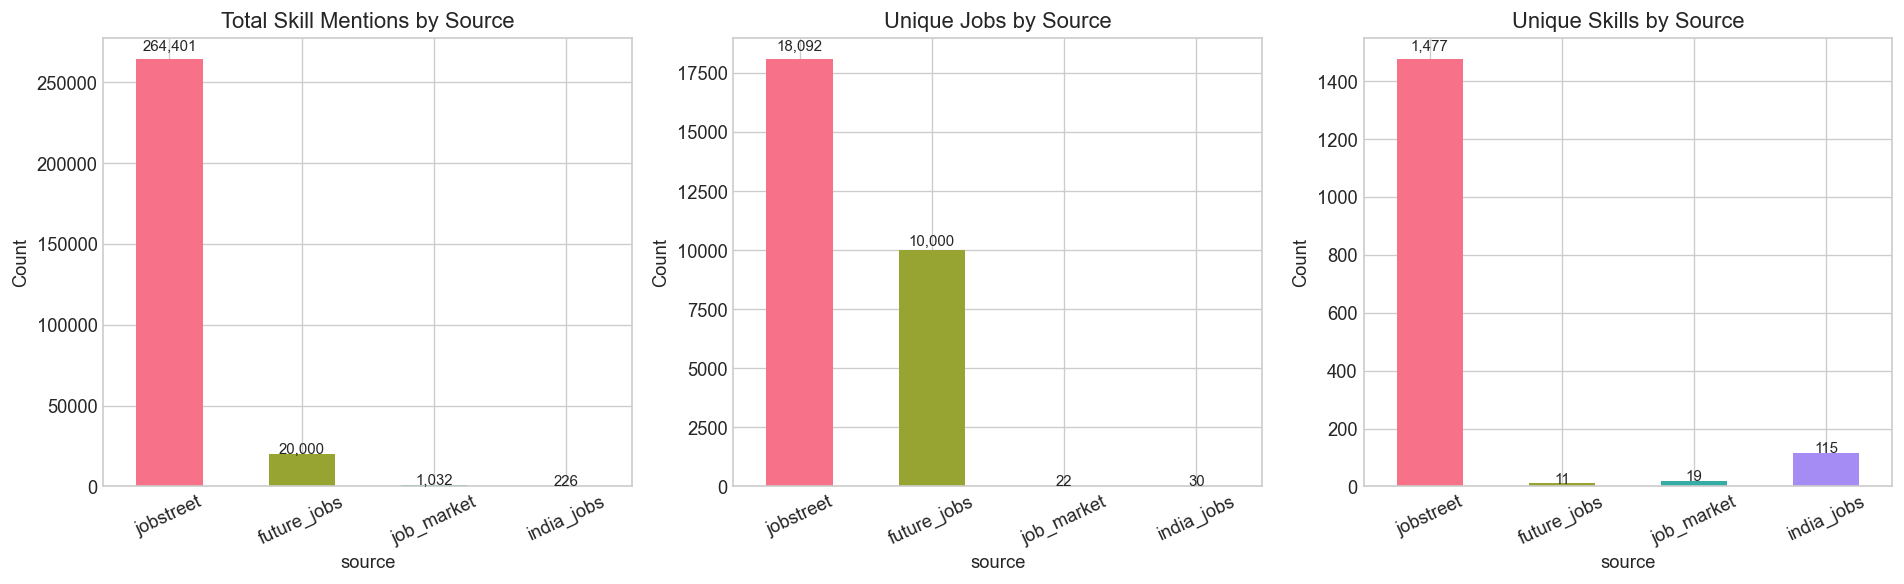


Date coverage by source:


,min,max,count
source,,,
future_jobs,2025-01-01,2025-12-31,20000
india_jobs,NaT,NaT,0
job_market,2025-11-27,2025-11-27,1032
jobstreet,NaT,NaT,0


In [4]:
# Dataset row counts by source
source_counts = df_mapping.groupby('source').agg(
    skill_mentions=('skill', 'count'),
    unique_jobs=('job_id', 'nunique'),
    unique_skills=('skill', 'nunique'),
).sort_values('skill_mentions', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

source_counts['skill_mentions'].plot(kind='bar', ax=axes[0], color=sns.color_palette('husl', len(source_counts)))
axes[0].set_title('Total Skill Mentions by Source')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=25)
for i, v in enumerate(source_counts['skill_mentions']):
    axes[0].text(i, v + v*0.02, f'{v:,}', ha='center', fontsize=9)

source_counts['unique_jobs'].plot(kind='bar', ax=axes[1], color=sns.color_palette('husl', len(source_counts)))
axes[1].set_title('Unique Jobs by Source')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=25)
for i, v in enumerate(source_counts['unique_jobs']):
    axes[1].text(i, v + v*0.02, f'{v:,}', ha='center', fontsize=9)

source_counts['unique_skills'].plot(kind='bar', ax=axes[2], color=sns.color_palette('husl', len(source_counts)))
axes[2].set_title('Unique Skills by Source')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=25)
for i, v in enumerate(source_counts['unique_skills']):
    axes[2].text(i, v + v*0.02, f'{v:,}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIG_DIR / '01_dataset_overview.png', bbox_inches='tight')
plt.show()

# Date ranges
print('\nDate coverage by source:')
date_summary = df_mapping.groupby('source')['posting_date'].agg(['min', 'max', 'count'])
display(date_summary)

## 3.3 Skill Frequency Analysis

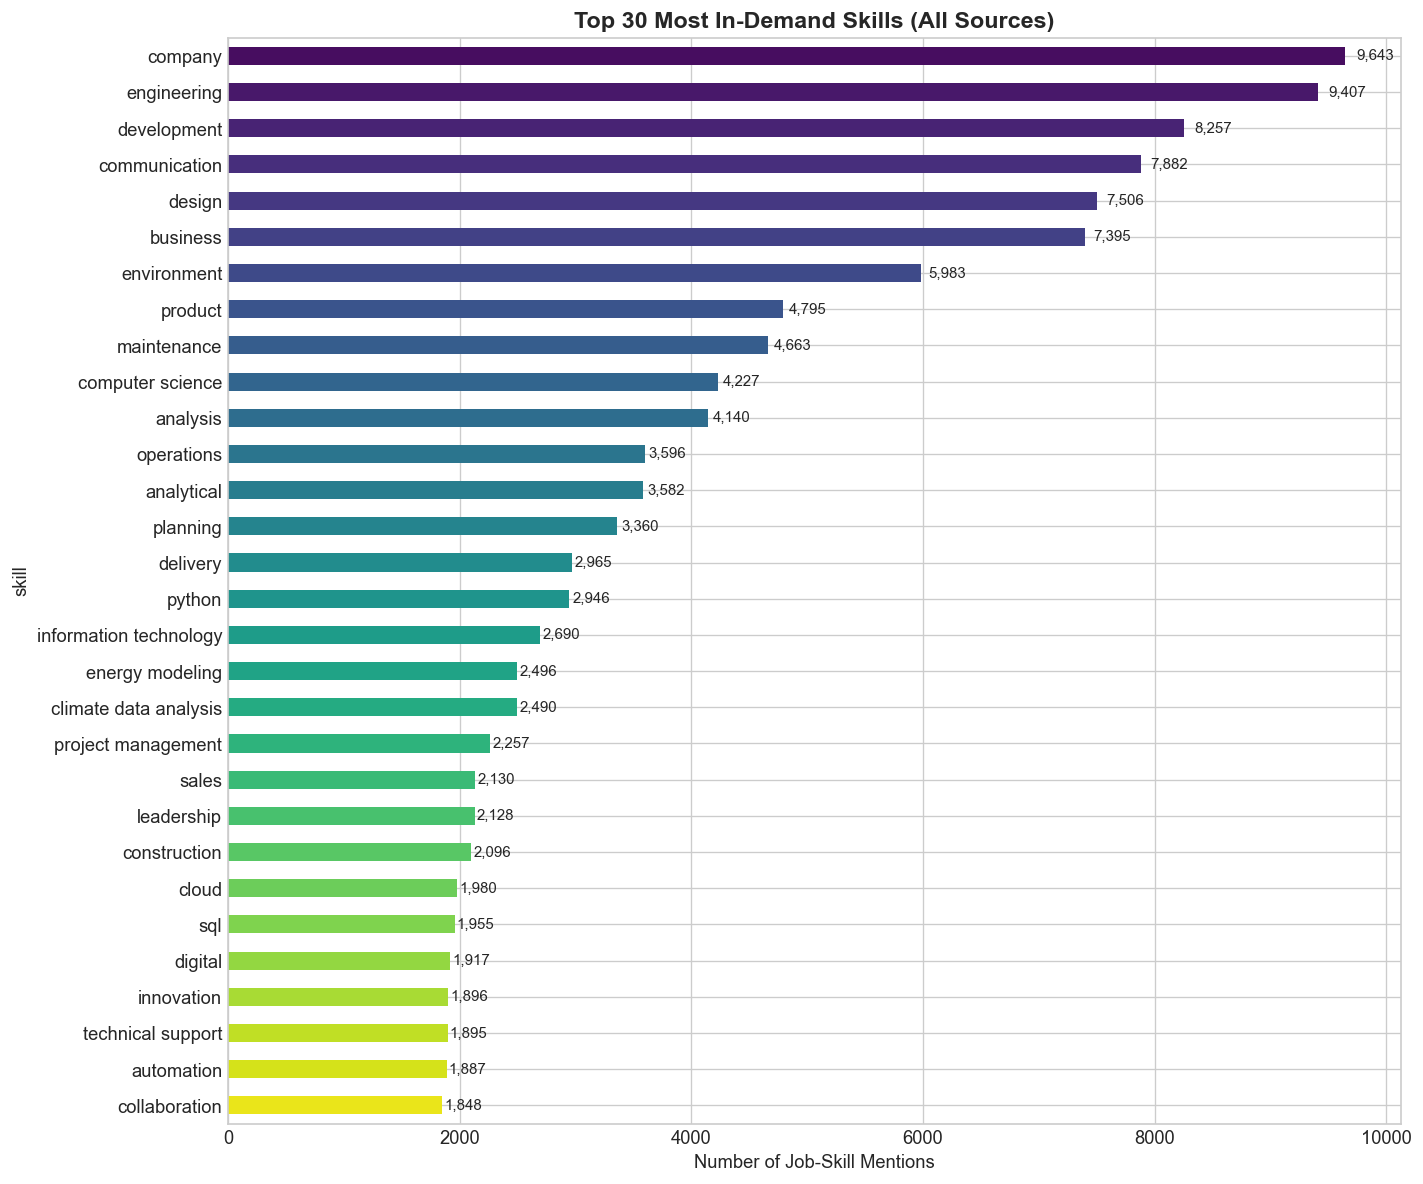

In [5]:
# 1. Top 30 Most Demanded Skills (Overall)
skill_counts = df_mapping['skill'].value_counts()

fig, ax = plt.subplots(figsize=(12, 10))
top30 = skill_counts.head(30)
colors = sns.color_palette('viridis', len(top30))
top30.iloc[::-1].plot(kind='barh', ax=ax, color=colors[::-1])
ax.set_title('Top 30 Most In-Demand Skills (All Sources)', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Job-Skill Mentions')
for i, v in enumerate(top30.iloc[::-1]):
    ax.text(v + v*0.01, i, f'{v:,}', va='center', fontsize=9)
plt.tight_layout()
plt.savefig(FIG_DIR / '02_top30_skills_overall.png', bbox_inches='tight')
plt.show()

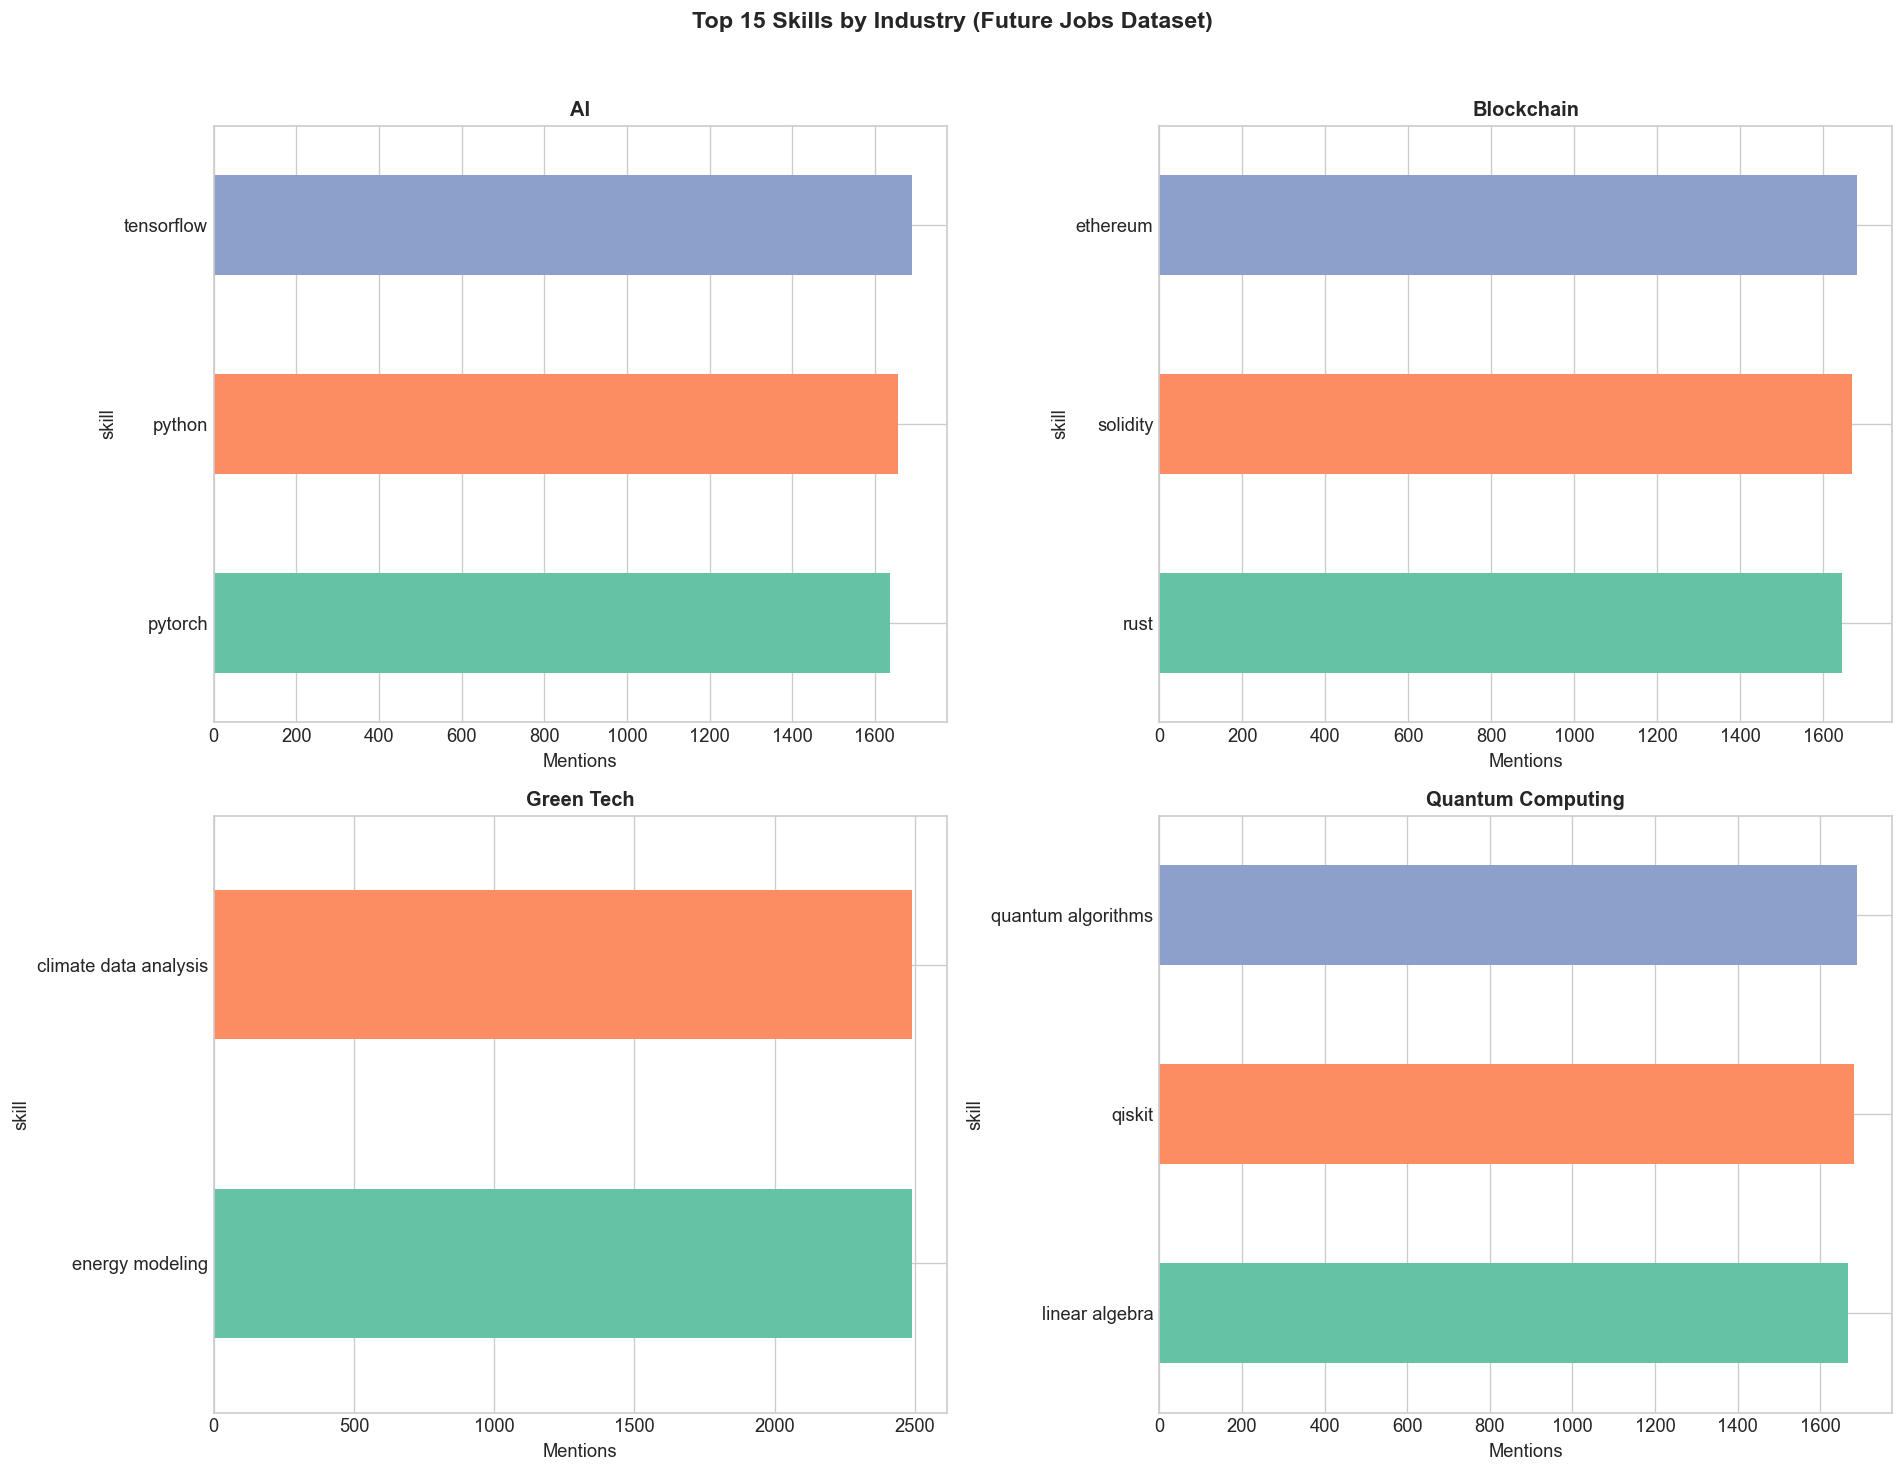

In [6]:
# 2. Top 15 Skills by Industry (from future_jobs_dataset)
future_mapping = df_mapping[df_mapping['source'] == 'future_jobs']
industries = future_mapping['industry'].unique()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, industry in enumerate(sorted(industries)):
    if idx >= 4:
        break
    industry_data = future_mapping[future_mapping['industry'] == industry]
    top_skills = industry_data['skill'].value_counts().head(15)
    top_skills.iloc[::-1].plot(kind='barh', ax=axes[idx], color=sns.color_palette('Set2', 15))
    axes[idx].set_title(f'{industry}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Mentions')

plt.suptitle('Top 15 Skills by Industry (Future Jobs Dataset)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / '03_top_skills_by_industry.png', bbox_inches='tight')
plt.show()

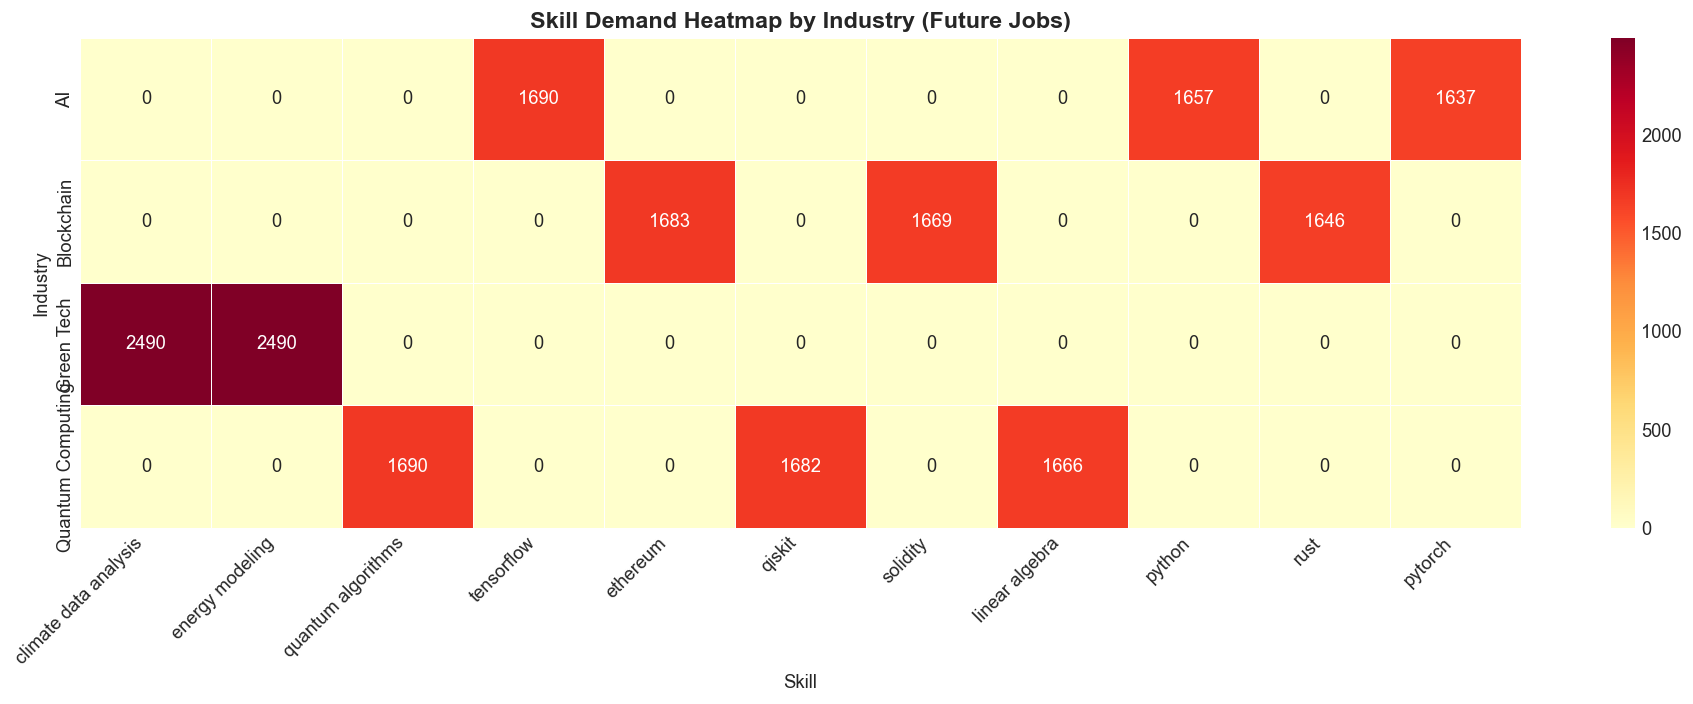

In [7]:
# 3. Skill-Industry Heatmap
# Use top 20 skills across all industries
top20_skills = future_mapping['skill'].value_counts().head(20).index
heatmap_data = future_mapping[future_mapping['skill'].isin(top20_skills)]

pivot = heatmap_data.groupby(['industry', 'skill']).size().unstack(fill_value=0)
# Reorder columns by total frequency
pivot = pivot[top20_skills[top20_skills.isin(pivot.columns)]]

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlOrRd', ax=ax, linewidths=0.5)
ax.set_title('Skill Demand Heatmap by Industry (Future Jobs)', fontsize=14, fontweight='bold')
ax.set_ylabel('Industry')
ax.set_xlabel('Skill')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(FIG_DIR / '04_skill_industry_heatmap.png', bbox_inches='tight')
plt.show()

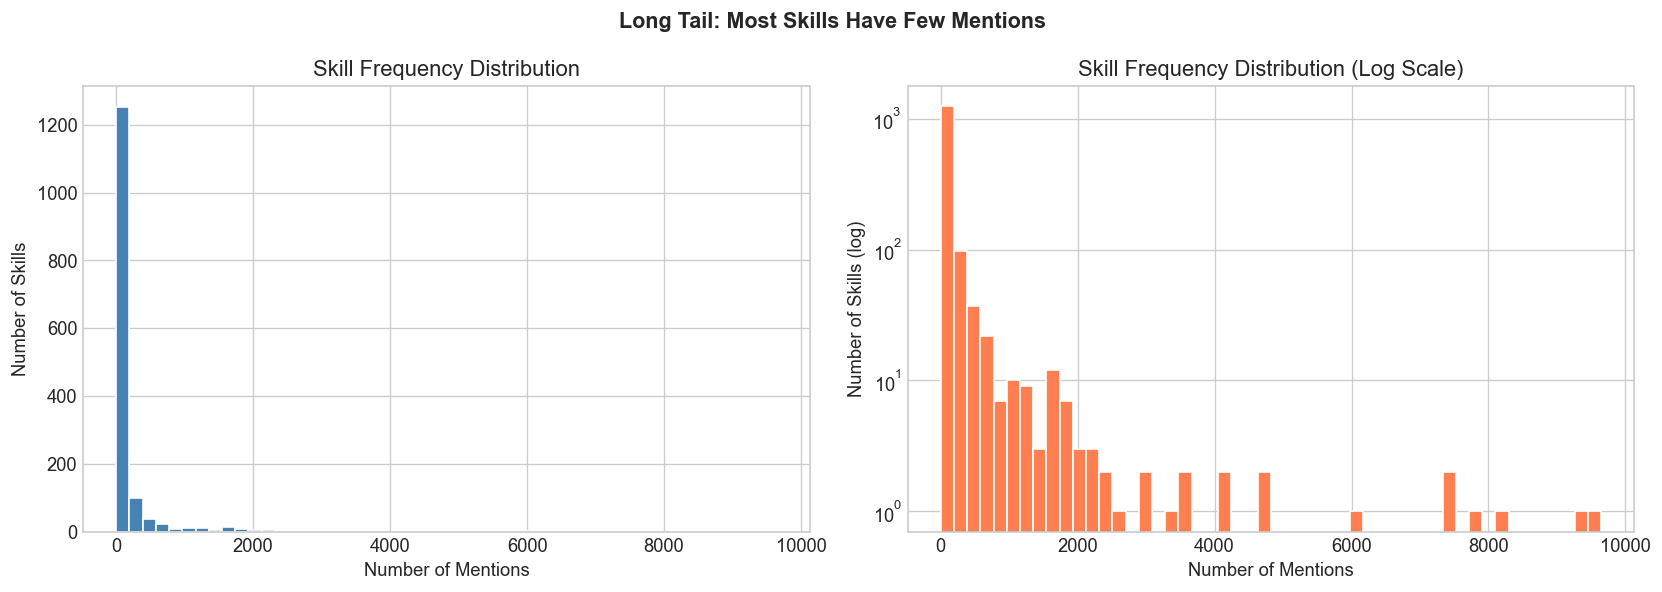

Skills with > 100 mentions: 387
Skills with 10-100 mentions: 702
Skills with < 10 mentions: 394


In [8]:
# 4. Long Tail Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].hist(skill_counts.values, bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Skill Frequency Distribution')
axes[0].set_xlabel('Number of Mentions')
axes[0].set_ylabel('Number of Skills')

# Log scale
axes[1].hist(skill_counts.values, bins=50, color='coral', edgecolor='white', log=True)
axes[1].set_title('Skill Frequency Distribution (Log Scale)')
axes[1].set_xlabel('Number of Mentions')
axes[1].set_ylabel('Number of Skills (log)')

plt.suptitle('Long Tail: Most Skills Have Few Mentions', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / '05_skill_frequency_distribution.png', bbox_inches='tight')
plt.show()

print(f'Skills with > 100 mentions: {(skill_counts > 100).sum()}')
print(f'Skills with 10-100 mentions: {((skill_counts >= 10) & (skill_counts <= 100)).sum()}')
print(f'Skills with < 10 mentions: {(skill_counts < 10).sum()}')

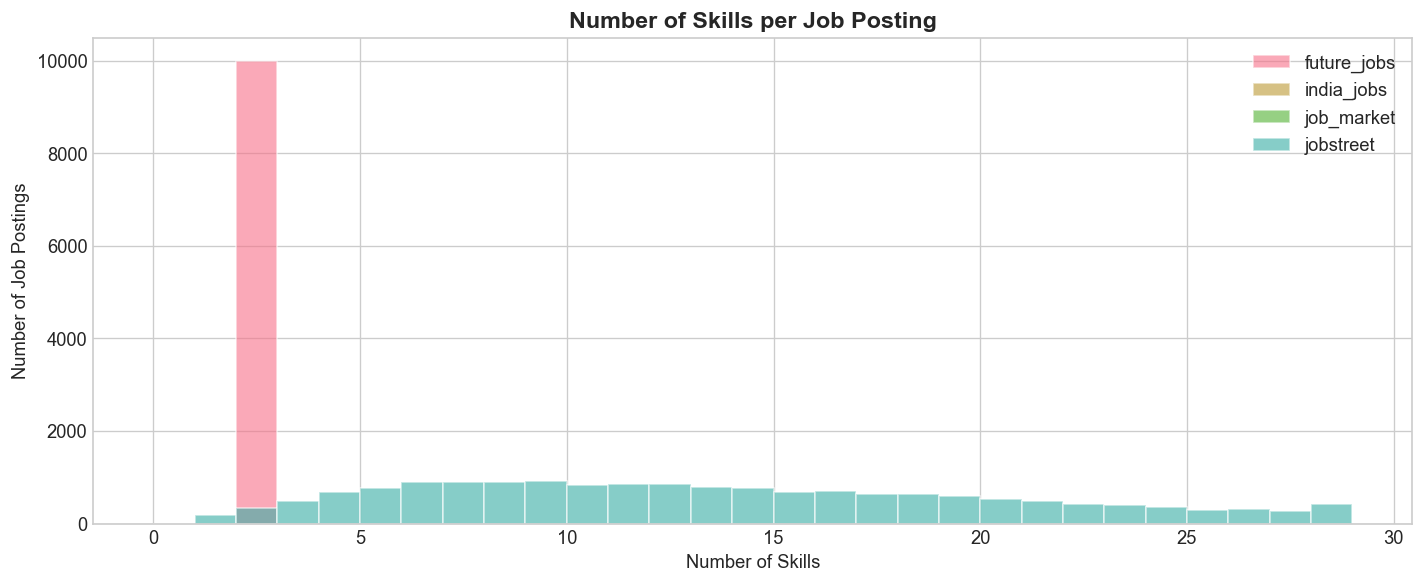

Average skills per job by source:
               count  mean   std   min   25%   50%   75%   max
source                                                        
future_jobs  10000.0   2.0   0.0   2.0   2.0   2.0   2.0   2.0
india_jobs      30.0   7.5   2.6   4.0   6.0   7.0   8.0  16.0
job_market      22.0  46.9  13.0  27.0  38.0  44.5  50.0  76.0
jobstreet    18092.0  14.6   8.8   1.0   8.0  13.0  20.0  66.0


In [9]:
# 5. Skills per Job Posting
skills_per_job = df_mapping.groupby(['source', 'job_id']).size().reset_index(name='num_skills')

fig, ax = plt.subplots(figsize=(12, 5))
for source in skills_per_job['source'].unique():
    subset = skills_per_job[skills_per_job['source'] == source]
    ax.hist(subset['num_skills'], bins=range(0, 30), alpha=0.6, label=source, edgecolor='white')

ax.set_title('Number of Skills per Job Posting', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Skills')
ax.set_ylabel('Number of Job Postings')
ax.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / '06_skills_per_job.png', bbox_inches='tight')
plt.show()

print('Average skills per job by source:')
print(skills_per_job.groupby('source')['num_skills'].describe().round(1))

## 3.4 Skill Demand Over Time

In [10]:
# Filter to rows with valid dates
df_temporal = df_mapping.dropna(subset=['posting_date']).copy()
df_temporal['month'] = df_temporal['posting_date'].dt.to_period('M')

print(f'Rows with dates: {len(df_temporal):,} ({len(df_temporal)/len(df_mapping)*100:.1f}%)')
print(f'Date range: {df_temporal["posting_date"].min()} to {df_temporal["posting_date"].max()}')
print(f'Months covered: {df_temporal["month"].nunique()}')

Rows with dates: 21,032 (7.4%)
Date range: 2025-01-01 00:00:00 to 2025-12-31 00:00:00
Months covered: 12


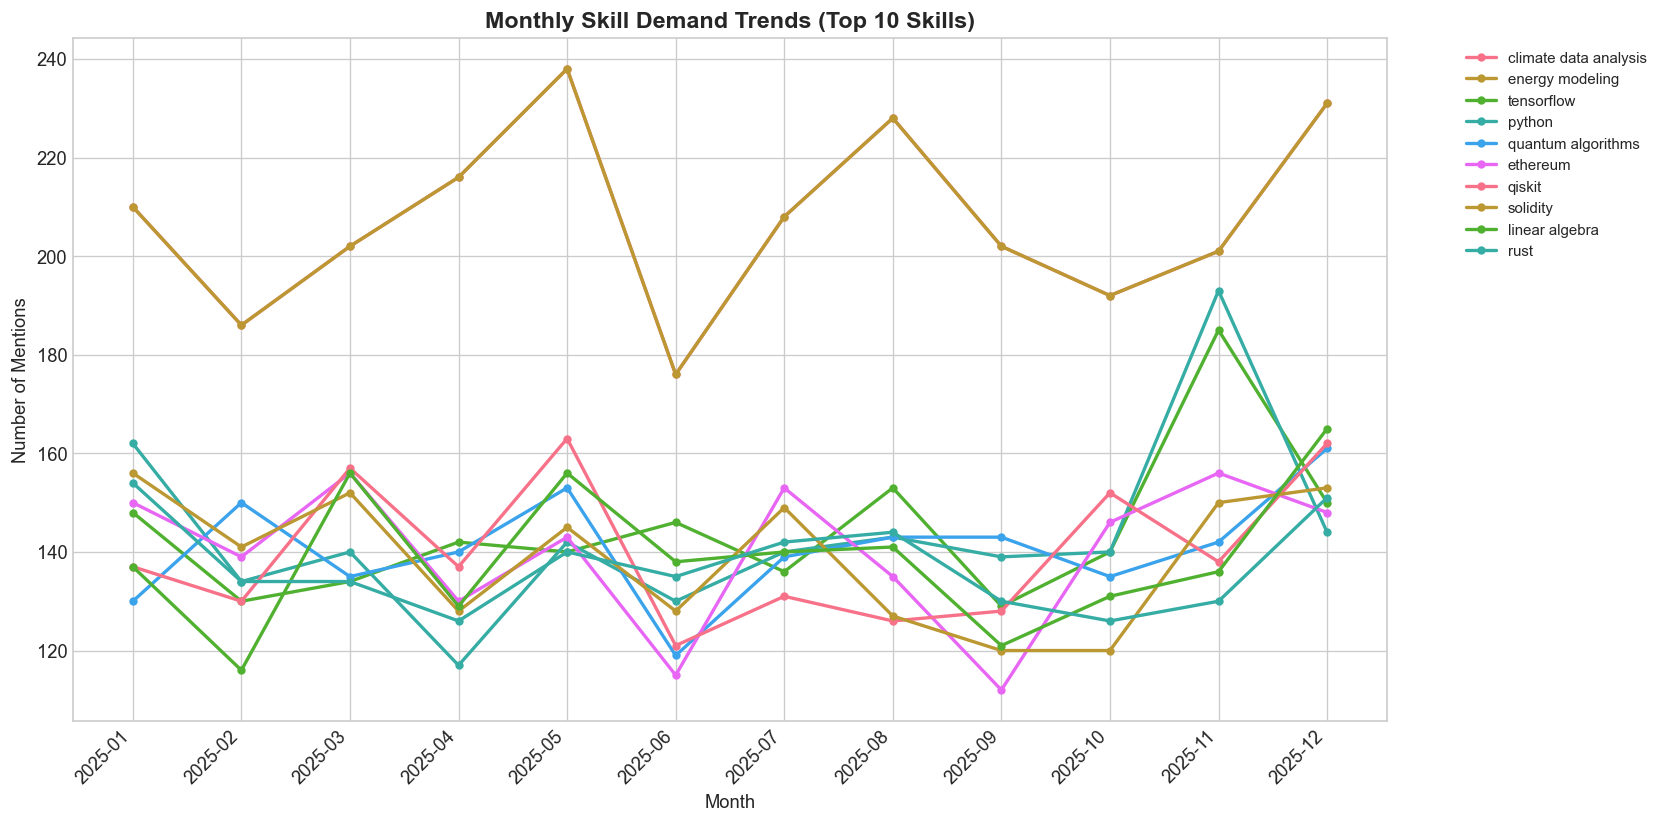

In [11]:
# 6. Monthly Skill Demand Trends (Top 10 skills)
top10_skills = df_temporal['skill'].value_counts().head(10).index
monthly_trends = (
    df_temporal[df_temporal['skill'].isin(top10_skills)]
    .groupby(['month', 'skill'])
    .size()
    .reset_index(name='count')
)
monthly_trends['month_str'] = monthly_trends['month'].astype(str)

fig, ax = plt.subplots(figsize=(14, 7))
for skill in top10_skills:
    skill_data = monthly_trends[monthly_trends['skill'] == skill].sort_values('month_str')
    ax.plot(skill_data['month_str'], skill_data['count'], marker='o', label=skill, linewidth=2, markersize=4)

ax.set_title('Monthly Skill Demand Trends (Top 10 Skills)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Mentions')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(FIG_DIR / '07_monthly_skill_trends.png', bbox_inches='tight')
plt.show()

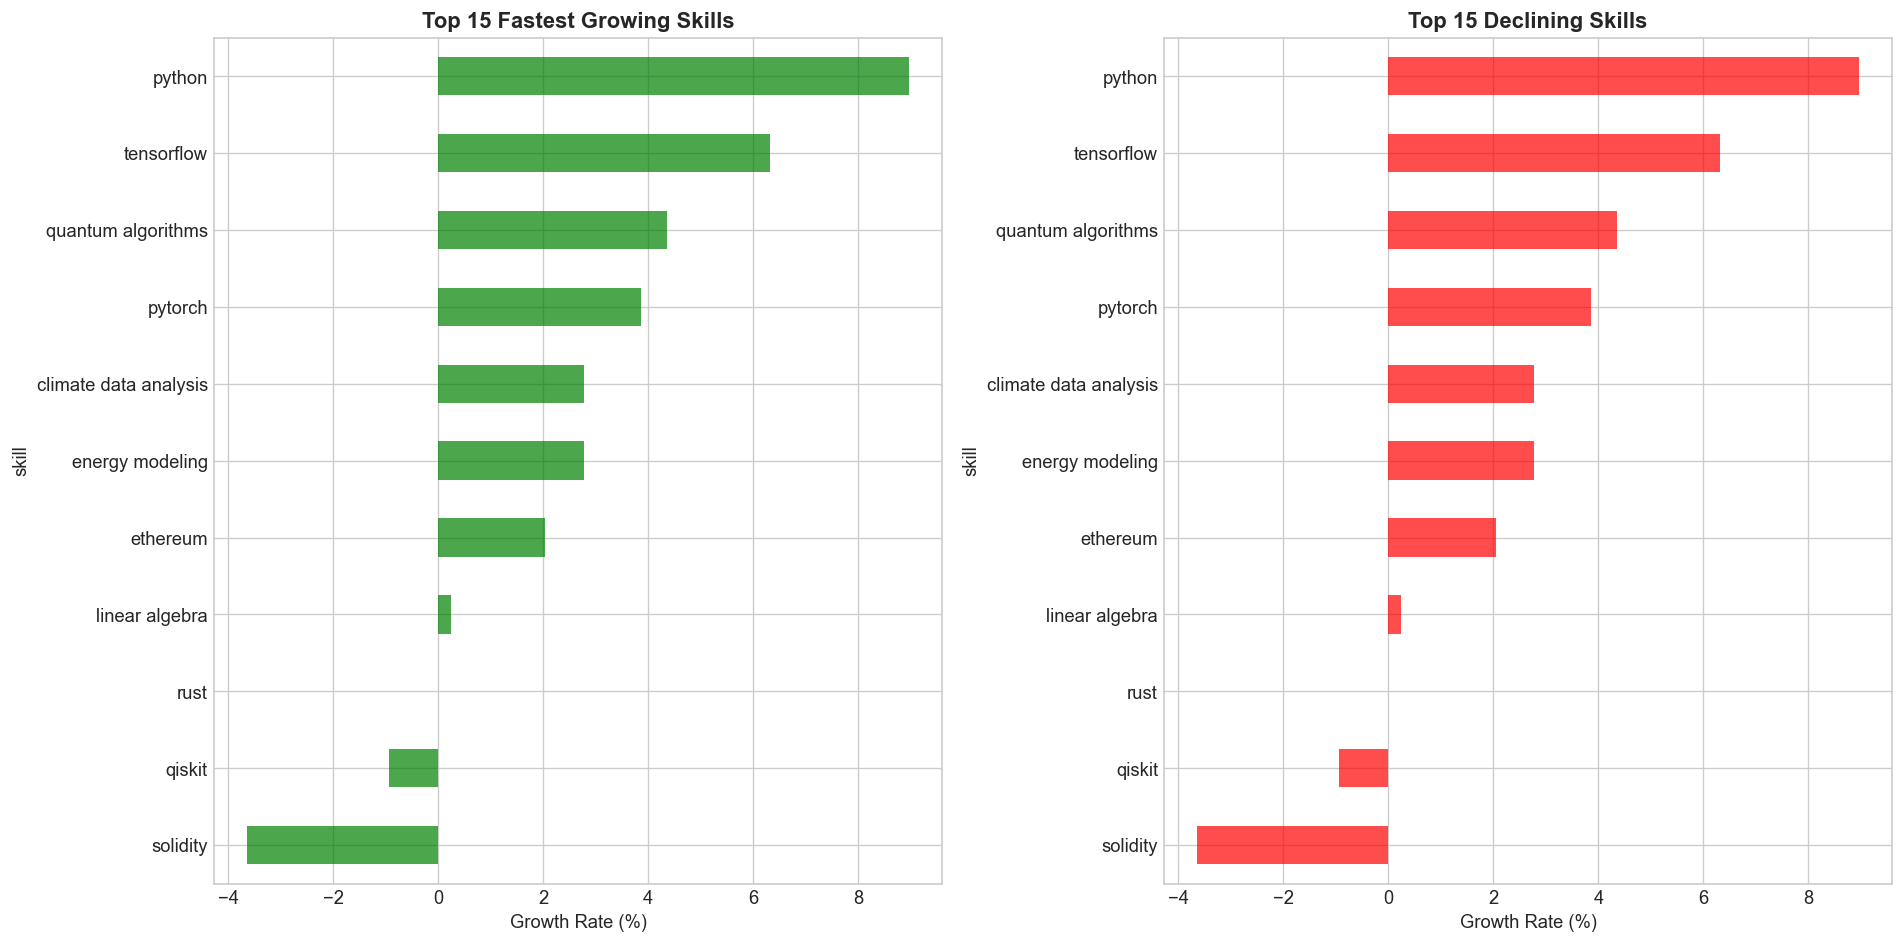

In [12]:
# 7. Skill Growth Rate Analysis
# Calculate monthly counts and growth rates
monthly_pivot = (
    df_temporal
    .groupby(['month', 'skill'])
    .size()
    .unstack(fill_value=0)
)

# Only analyze skills with sufficient data (present in at least 3 months)
month_presence = (monthly_pivot > 0).sum()
active_skills = month_presence[month_presence >= 3].index

# Calculate growth: compare last 3 months vs first 3 months
if len(monthly_pivot) >= 6:
    first_half = monthly_pivot.iloc[:len(monthly_pivot)//2][active_skills].mean()
    second_half = monthly_pivot.iloc[len(monthly_pivot)//2:][active_skills].mean()
    growth = ((second_half - first_half) / first_half.replace(0, np.nan) * 100).dropna()
else:
    # If not enough months, compare first vs last available
    first_period = monthly_pivot.iloc[0][active_skills]
    last_period = monthly_pivot.iloc[-1][active_skills]
    growth = ((last_period - first_period) / first_period.replace(0, np.nan) * 100).dropna()

growth_sorted = growth.sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top growing skills
top_growing = growth_sorted.head(15)
top_growing.iloc[::-1].plot(kind='barh', ax=axes[0], color='green', alpha=0.7)
axes[0].set_title('Top 15 Fastest Growing Skills', fontweight='bold')
axes[0].set_xlabel('Growth Rate (%)')

# Top declining skills
top_declining = growth_sorted.tail(15)
top_declining.iloc[::-1].plot(kind='barh', ax=axes[1], color='red', alpha=0.7)
axes[1].set_title('Top 15 Declining Skills', fontweight='bold')
axes[1].set_xlabel('Growth Rate (%)')

plt.tight_layout()
plt.savefig(FIG_DIR / '08_skill_growth_rates.png', bbox_inches='tight')
plt.show()

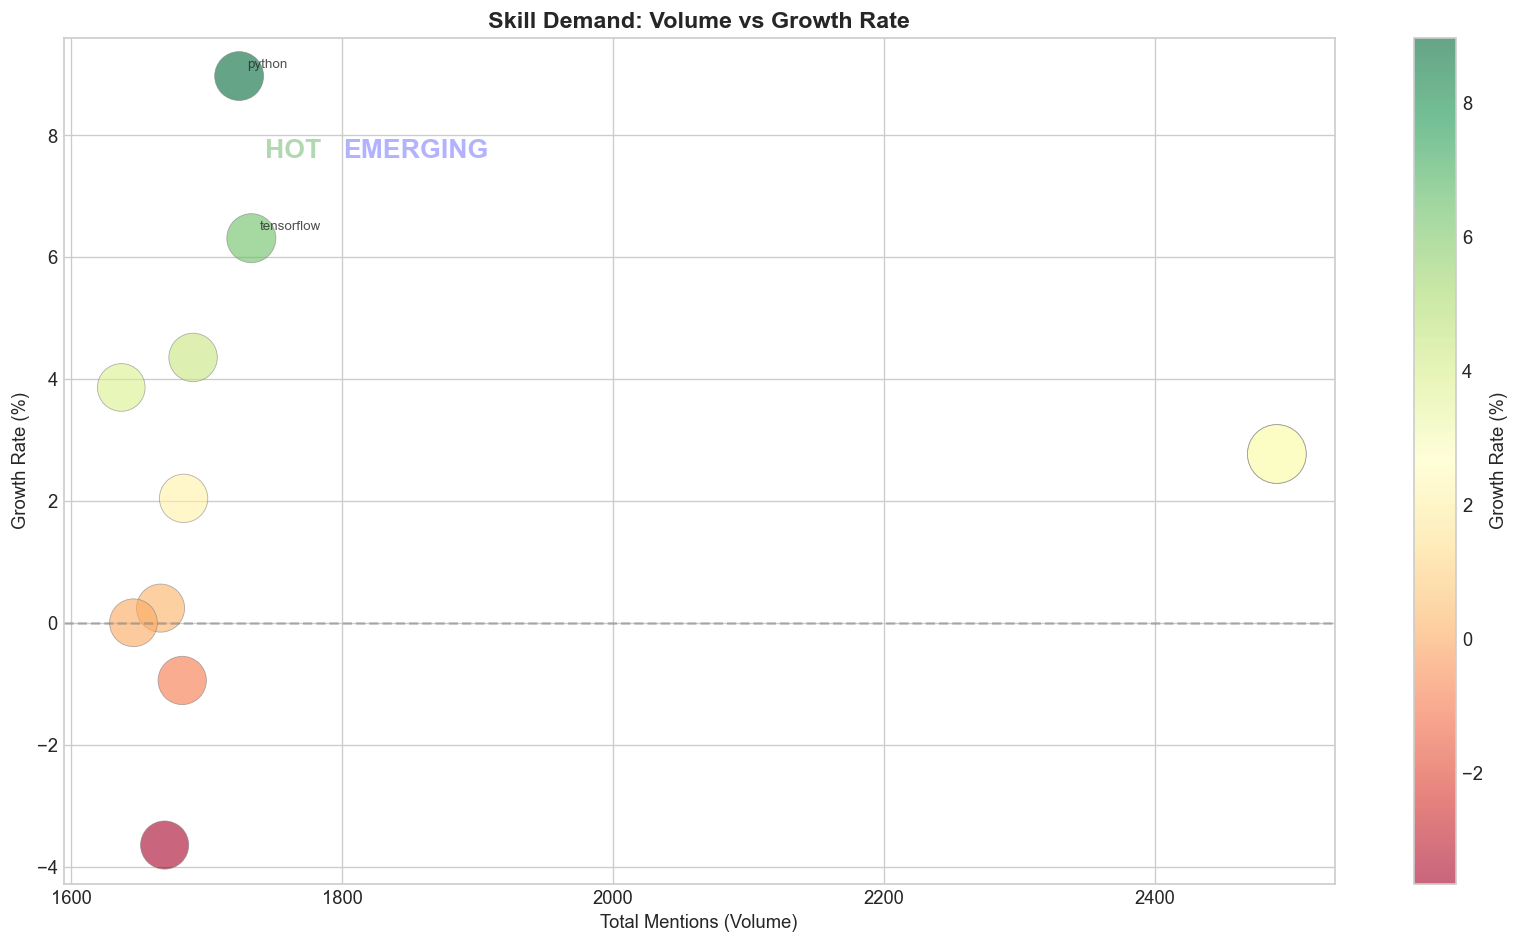

In [13]:
# 8. Emerging Skills Scatter: Total Count vs Growth Rate
total_counts = df_temporal[df_temporal['skill'].isin(growth.index)].groupby('skill').size()

scatter_df = pd.DataFrame({
    'total_count': total_counts,
    'growth_rate': growth
}).dropna()

fig, ax = plt.subplots(figsize=(14, 8))
scatter = ax.scatter(
    scatter_df['total_count'],
    scatter_df['growth_rate'],
    s=scatter_df['total_count'] * 0.5,
    alpha=0.6,
    c=scatter_df['growth_rate'],
    cmap='RdYlGn',
    edgecolors='gray',
    linewidth=0.5,
)

# Label notable skills
# Top-right (high count + high growth = HOT)
# Top-left (low count + high growth = EMERGING)
for skill, row in scatter_df.iterrows():
    # Label top skills by growth or count
    if (row['growth_rate'] > scatter_df['growth_rate'].quantile(0.85) or
        row['total_count'] > scatter_df['total_count'].quantile(0.9)):
        ax.annotate(skill, (row['total_count'], row['growth_rate']),
                   fontsize=8, alpha=0.8,
                   xytext=(5, 5), textcoords='offset points')

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_title('Skill Demand: Volume vs Growth Rate', fontsize=14, fontweight='bold')
ax.set_xlabel('Total Mentions (Volume)')
ax.set_ylabel('Growth Rate (%)')
plt.colorbar(scatter, label='Growth Rate (%)')

# Quadrant labels
mid_x = scatter_df['total_count'].median()
mid_y = 0
ax.text(scatter_df['total_count'].max() * 0.7, scatter_df['growth_rate'].max() * 0.85,
        'HOT', fontsize=16, alpha=0.3, color='green', fontweight='bold')
ax.text(scatter_df['total_count'].min() * 1.1, scatter_df['growth_rate'].max() * 0.85,
        'EMERGING', fontsize=16, alpha=0.3, color='blue', fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / '09_emerging_skills_scatter.png', bbox_inches='tight')
plt.show()

## 3.5 Skill Co-occurrence Analysis

In [14]:
# Build co-occurrence from skills lists across all datasets
# Use the individual datasets with skills_list columns
all_skills_lists = []

for df in [df_future, df_india, df_market]:
    for skills in df['skills_list']:
        if isinstance(skills, list) and len(skills) >= 2:
            all_skills_lists.append(skills)

# Also load jobstreet skills lists
try:
    df_js = pd.read_parquet(PROCESS_DIR / 'cleaned_jobstreet_skills.parquet', columns=['skills_list'])
    for skills in df_js['skills_list']:
        if isinstance(skills, list) and len(skills) >= 2:
            all_skills_lists.append(skills)
    del df_js
except Exception as e:
    print(f'Could not load jobstreet skills: {e}')

print(f'Job postings with 2+ skills: {len(all_skills_lists):,}')

# Count co-occurrences
co_occurrence = Counter()
for skills in all_skills_lists:
    for s1, s2 in combinations(sorted(set(skills)), 2):
        co_occurrence[(s1, s2)] += 1

print(f'Unique skill pairs: {len(co_occurrence):,}')
print(f'\nTop 15 co-occurring pairs:')
for (s1, s2), count in co_occurrence.most_common(15):
    print(f'  {s1:30s} + {s2:30s} = {count}')

Job postings with 2+ skills: 0
Unique skill pairs: 0

Top 15 co-occurring pairs:


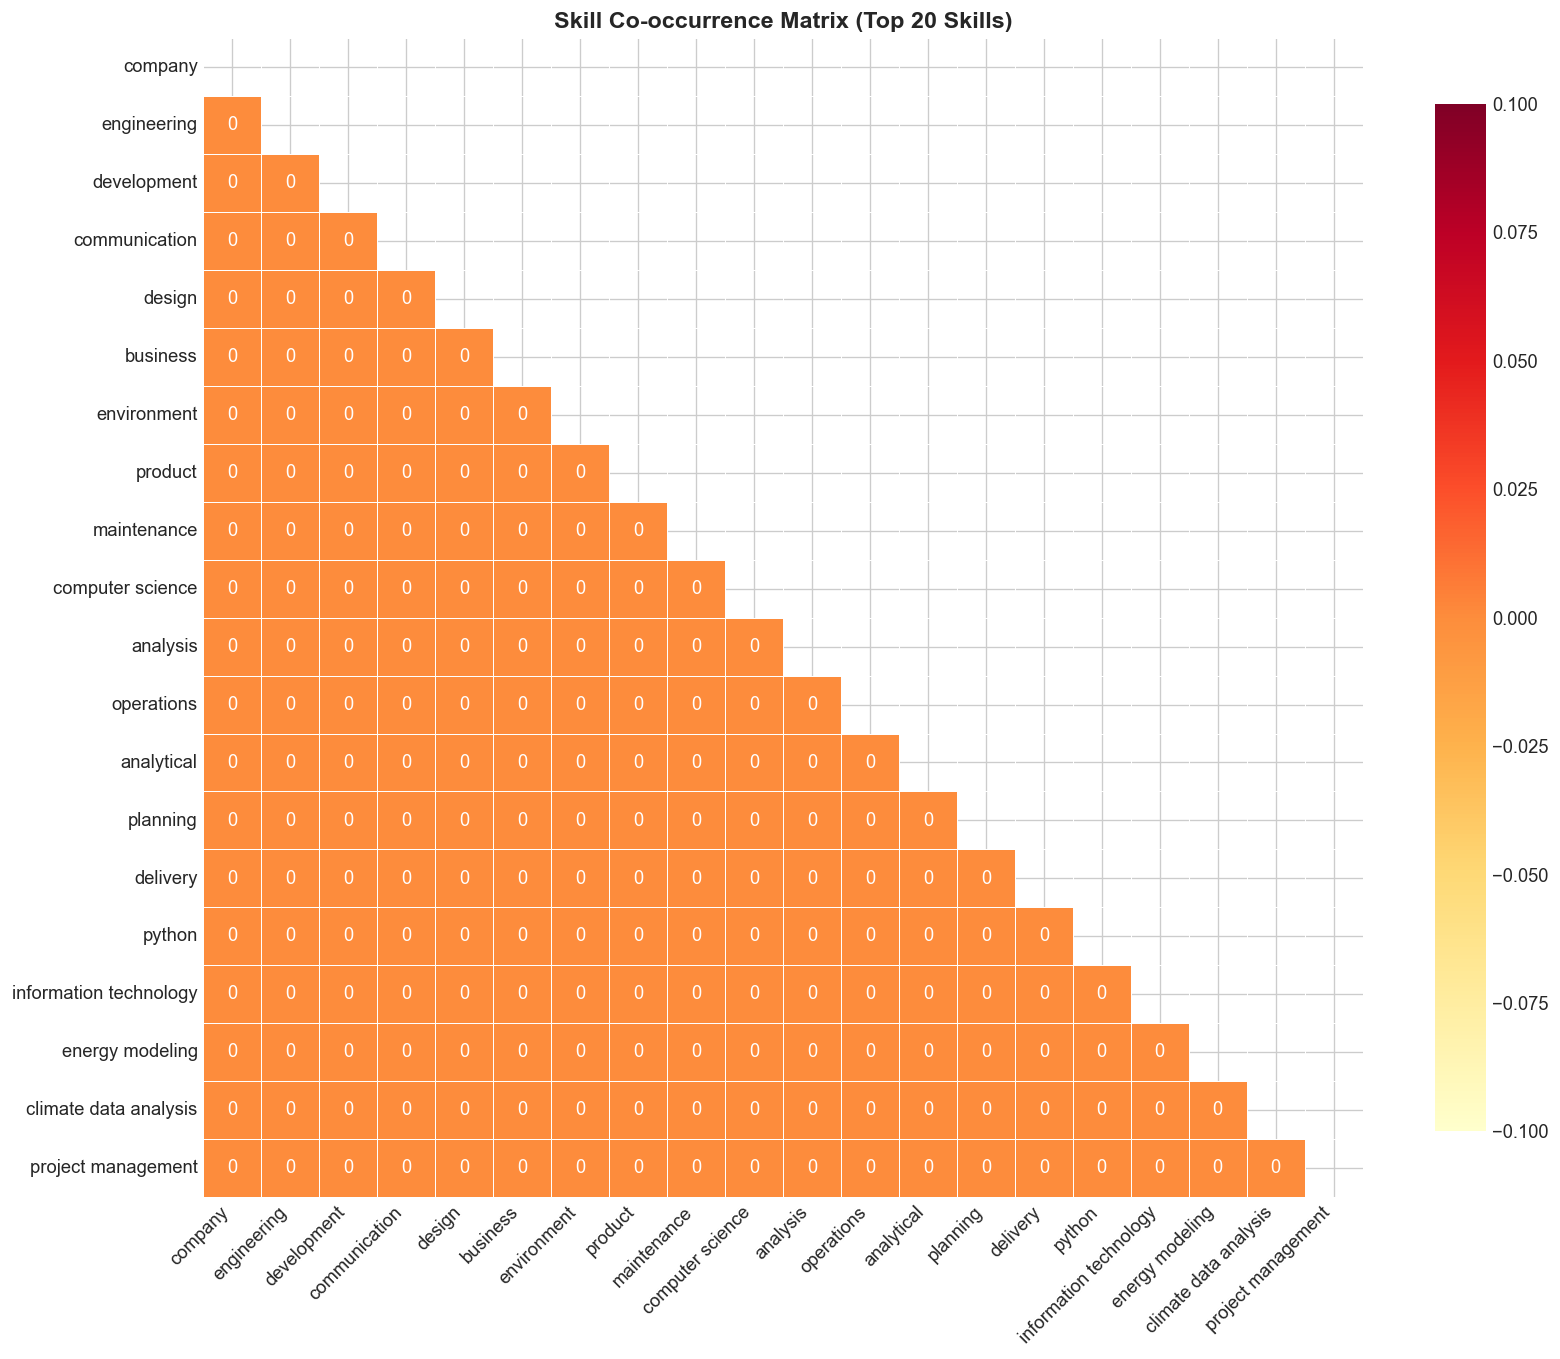

In [15]:
# 9. Co-occurrence Heatmap (Top 20 skills)
top20 = df_mapping['skill'].value_counts().head(20).index.tolist()

# Build co-occurrence matrix for top 20
cooc_matrix = pd.DataFrame(0, index=top20, columns=top20)
for (s1, s2), count in co_occurrence.items():
    if s1 in top20 and s2 in top20:
        cooc_matrix.loc[s1, s2] = count
        cooc_matrix.loc[s2, s1] = count

# Mask the diagonal and upper triangle
mask = np.triu(np.ones_like(cooc_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(cooc_matrix, mask=mask, annot=True, fmt='d', cmap='YlOrRd',
            ax=ax, linewidths=0.5, square=True, cbar_kws={'shrink': 0.8})
ax.set_title('Skill Co-occurrence Matrix (Top 20 Skills)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(FIG_DIR / '10_skill_cooccurrence_heatmap.png', bbox_inches='tight')
plt.show()

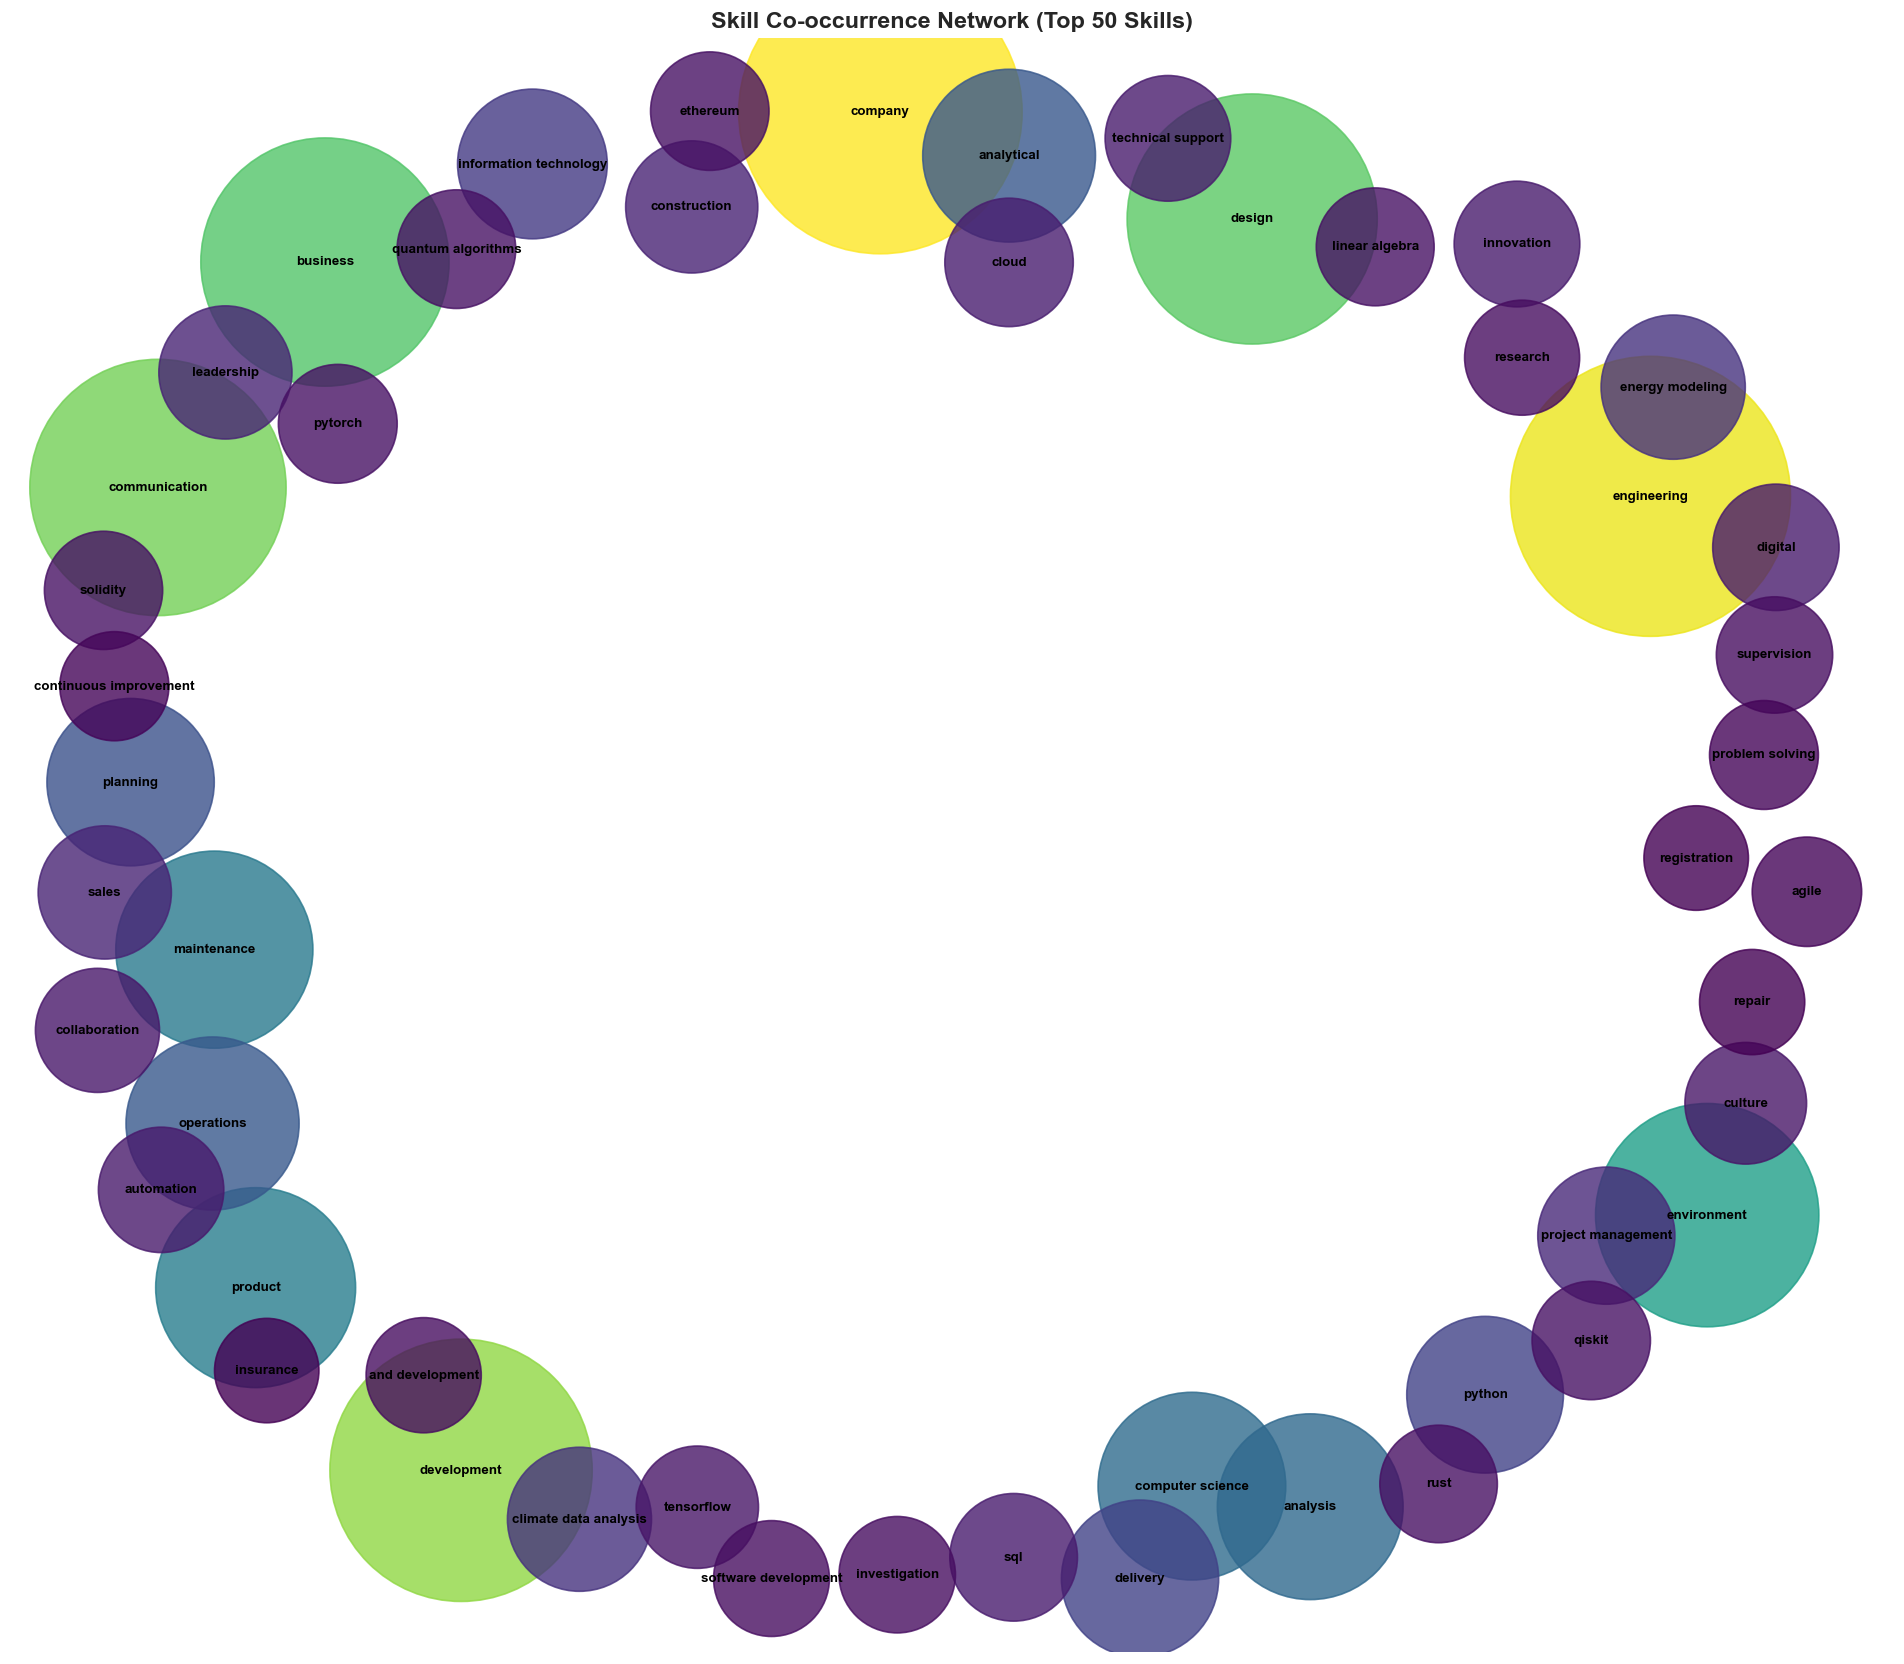

Network: 50 nodes, 0 edges


In [16]:
# 10. Skill Network Graph
# Build graph from top co-occurring pairs
G = nx.Graph()

# Add nodes with frequency as attribute
top50_skills = df_mapping['skill'].value_counts().head(50)
for skill, count in top50_skills.items():
    G.add_node(skill, frequency=count)

# Add edges from co-occurrence (only between top 50 skills)
top50_set = set(top50_skills.index)
min_cooc = 5  # minimum co-occurrence threshold for an edge
for (s1, s2), count in co_occurrence.items():
    if s1 in top50_set and s2 in top50_set and count >= min_cooc:
        G.add_edge(s1, s2, weight=count)

fig, ax = plt.subplots(figsize=(16, 14))

# Layout
pos = nx.spring_layout(G, k=2.5, iterations=50, seed=42)

# Node sizes proportional to frequency
node_sizes = [G.nodes[n].get('frequency', 10) * 3 for n in G.nodes()]

# Edge widths proportional to co-occurrence
edge_weights = [G.edges[e].get('weight', 1) for e in G.edges()]
max_weight = max(edge_weights) if edge_weights else 1
edge_widths = [w / max_weight * 4 for w in edge_weights]

# Draw
nx.draw_networkx_edges(G, pos, alpha=0.2, width=edge_widths, edge_color='gray', ax=ax)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_sizes,
                       cmap='viridis', alpha=0.8, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax)

ax.set_title('Skill Co-occurrence Network (Top 50 Skills)', fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.savefig(FIG_DIR / '11_skill_network_graph.png', bbox_inches='tight')
plt.show()

print(f'Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges')

In [17]:
# 11. Skill Cluster Dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# Build distance matrix from co-occurrence of top 25 skills
top25 = df_mapping['skill'].value_counts().head(25).index.tolist()
cooc_25 = pd.DataFrame(0, index=top25, columns=top25, dtype=float)
for (s1, s2), count in co_occurrence.items():
    if s1 in top25 and s2 in top25:
        cooc_25.loc[s1, s2] = count
        cooc_25.loc[s2, s1] = count

# Normalize to similarity (0-1), then convert to distance
max_val = cooc_25.max().max()
if max_val > 0:
    similarity = cooc_25 / max_val
    distance = 1 - similarity
    np.fill_diagonal(distance.values, 0)
    
    # Ensure symmetry and non-negative
    distance = (distance + distance.T) / 2
    distance = distance.clip(lower=0)
    
    condensed = squareform(distance.values)
    Z = linkage(condensed, method='ward')
    
    fig, ax = plt.subplots(figsize=(14, 8))
    dendrogram(Z, labels=top25, leaf_rotation=45, leaf_font_size=10, ax=ax)
    ax.set_title('Skill Clusters by Co-occurrence Similarity', fontsize=14, fontweight='bold')
    ax.set_ylabel('Distance')
    plt.tight_layout()
    plt.savefig(FIG_DIR / '12_skill_dendrogram.png', bbox_inches='tight')
    plt.show()
else:
    print('Insufficient co-occurrence data for dendrogram')

Insufficient co-occurrence data for dendrogram


## 3.6 Geographic Skill Distribution

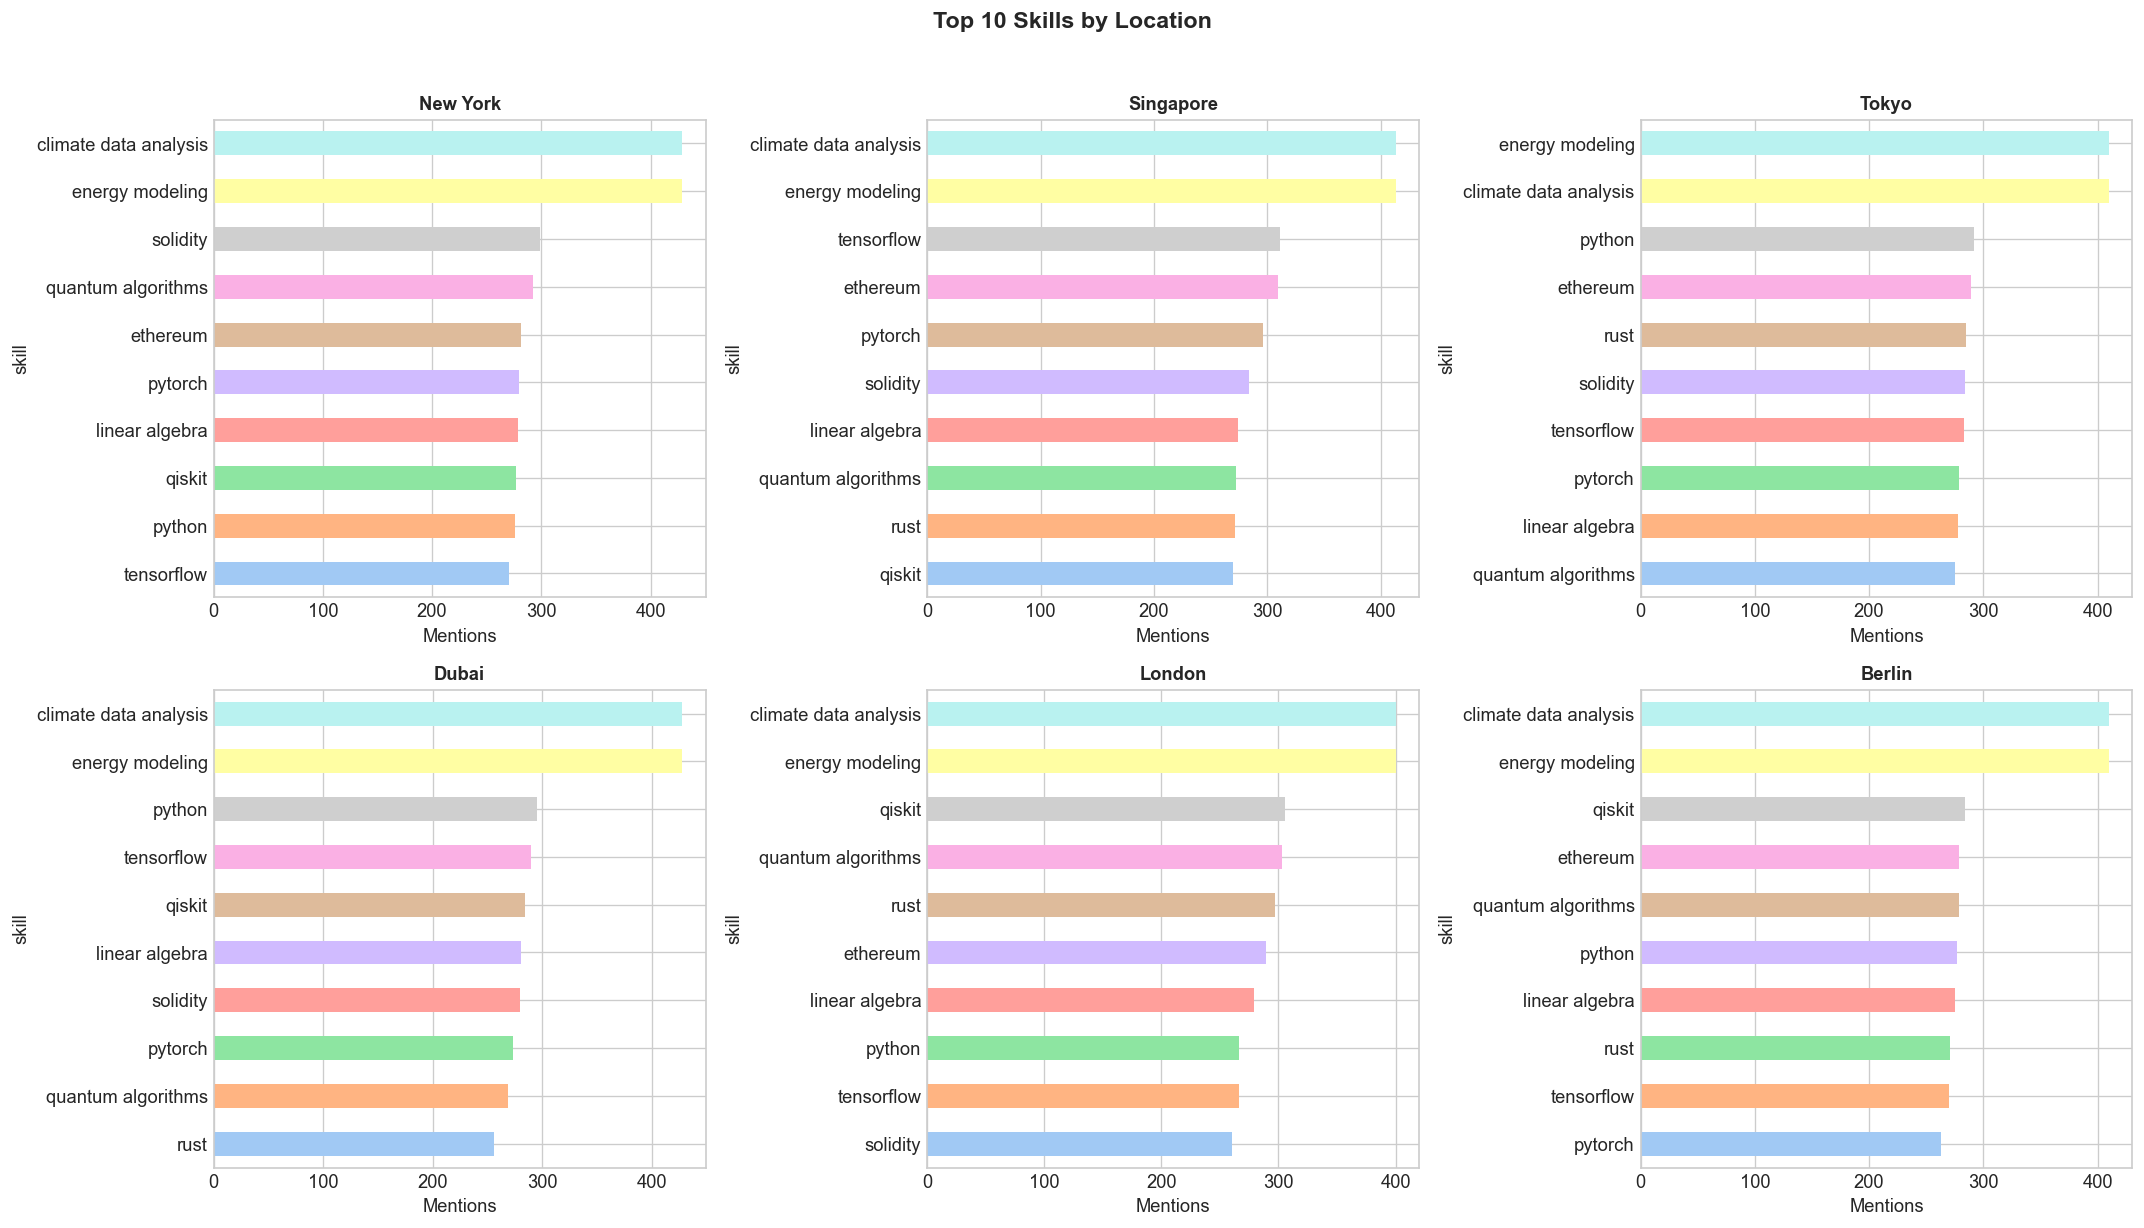

In [18]:
# 12. Top Skills by Location (from future_jobs which has 6 global locations)
future_with_loc = df_mapping[(df_mapping['source'] == 'future_jobs') & (df_mapping['location'] != '')]
locations = future_with_loc['location'].value_counts().head(6).index

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, loc in enumerate(locations):
    loc_data = future_with_loc[future_with_loc['location'] == loc]
    top_skills = loc_data['skill'].value_counts().head(10)
    top_skills.iloc[::-1].plot(kind='barh', ax=axes[idx], color=sns.color_palette('pastel', 10))
    axes[idx].set_title(f'{loc}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Mentions')

plt.suptitle('Top 10 Skills by Location', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / '13_top_skills_by_location.png', bbox_inches='tight')
plt.show()

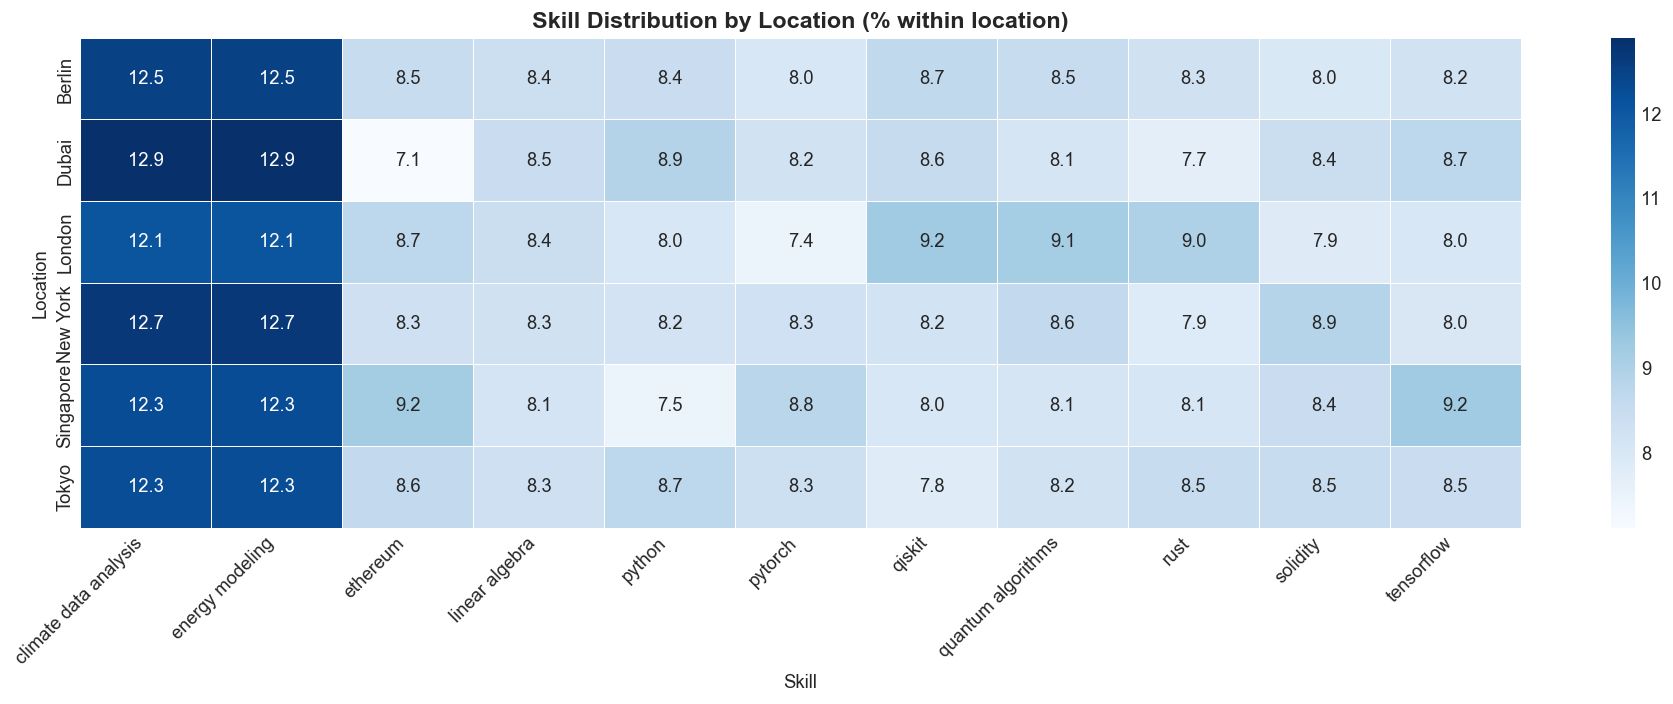

In [19]:
# 13. Location-Skill Heatmap
top15_skills_loc = future_with_loc['skill'].value_counts().head(15).index
loc_skill_data = future_with_loc[future_with_loc['skill'].isin(top15_skills_loc)]

pivot_loc = loc_skill_data.groupby(['location', 'skill']).size().unstack(fill_value=0)
# Normalize by location total to show proportions
pivot_loc_pct = pivot_loc.div(pivot_loc.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(pivot_loc_pct, annot=True, fmt='.1f', cmap='Blues', ax=ax, linewidths=0.5)
ax.set_title('Skill Distribution by Location (% within location)', fontsize=14, fontweight='bold')
ax.set_ylabel('Location')
ax.set_xlabel('Skill')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(FIG_DIR / '14_location_skill_heatmap.png', bbox_inches='tight')
plt.show()

## 3.7 Salary Correlation with Skills

Rows with salary data: 21,032
Sources with salary: {'future_jobs': 20000, 'job_market': 1032}


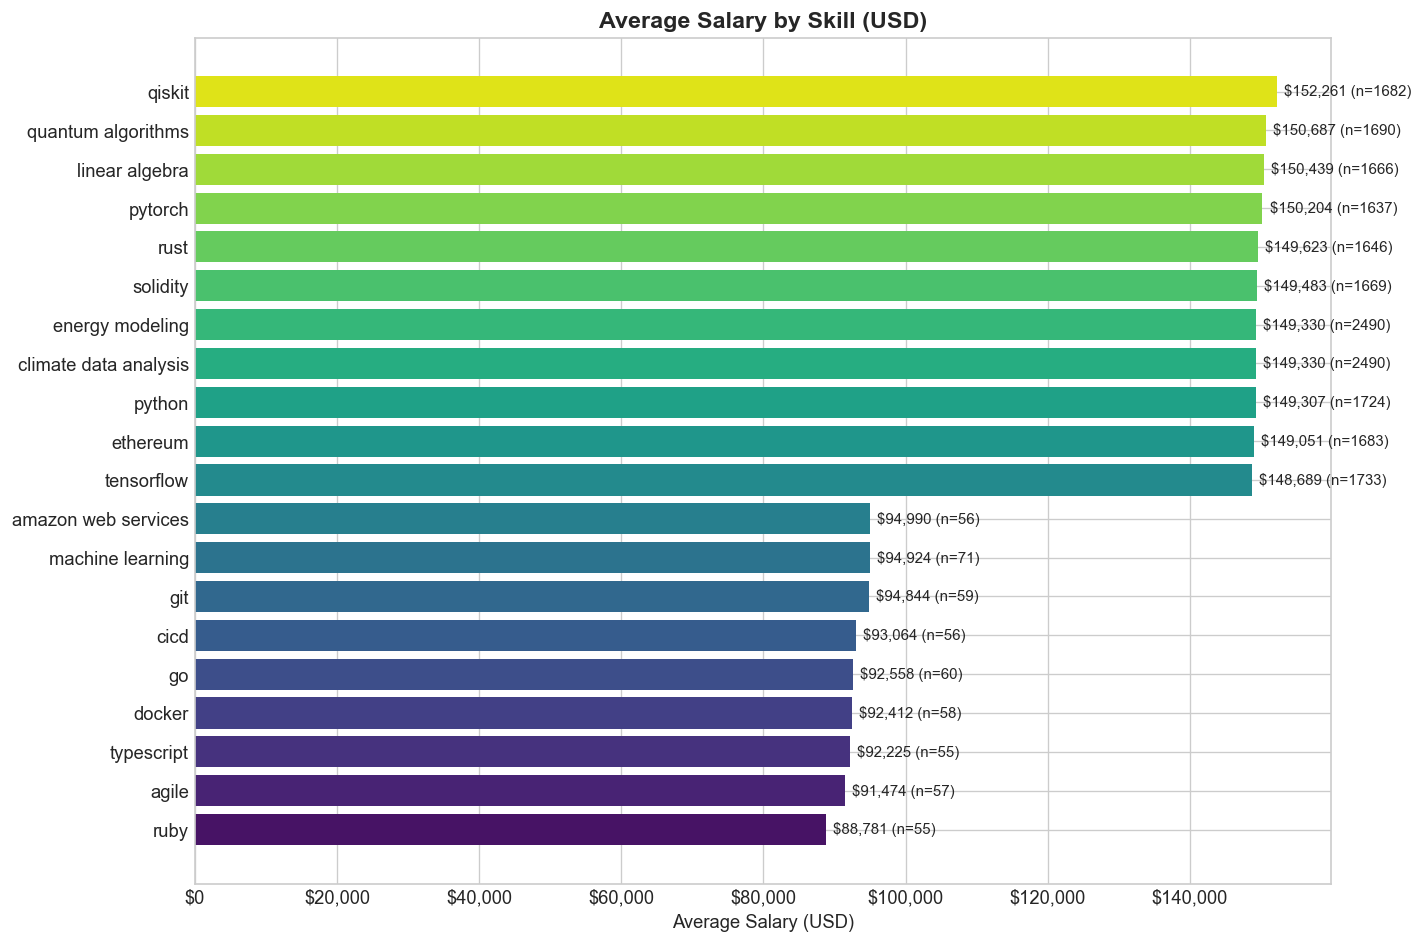

In [20]:
# 14. Average Salary by Skill (from future_jobs and job_market which have salary data)
salary_data = df_mapping[df_mapping['salary'].notna() & (df_mapping['salary'] > 0)]
print(f'Rows with salary data: {len(salary_data):,}')
print(f'Sources with salary: {salary_data["source"].value_counts().to_dict()}')

# Average salary by skill (top 20 most common skills that have salary data)
skill_salary = salary_data.groupby('skill').agg(
    avg_salary=('salary', 'mean'),
    median_salary=('salary', 'median'),
    count=('salary', 'count')
).sort_values('count', ascending=False)

# Only show skills with enough data points
skill_salary_top = skill_salary[skill_salary['count'] >= 10].head(20).sort_values('avg_salary', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(skill_salary_top.index, skill_salary_top['avg_salary'], color=sns.color_palette('viridis', len(skill_salary_top)))
ax.set_title('Average Salary by Skill (USD)', fontsize=14, fontweight='bold')
ax.set_xlabel('Average Salary (USD)')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
for i, (v, c) in enumerate(zip(skill_salary_top['avg_salary'], skill_salary_top['count'])):
    ax.text(v + 1000, i, f'${v:,.0f} (n={c})', va='center', fontsize=9)
plt.tight_layout()
plt.savefig(FIG_DIR / '15_salary_by_skill.png', bbox_inches='tight')
plt.show()

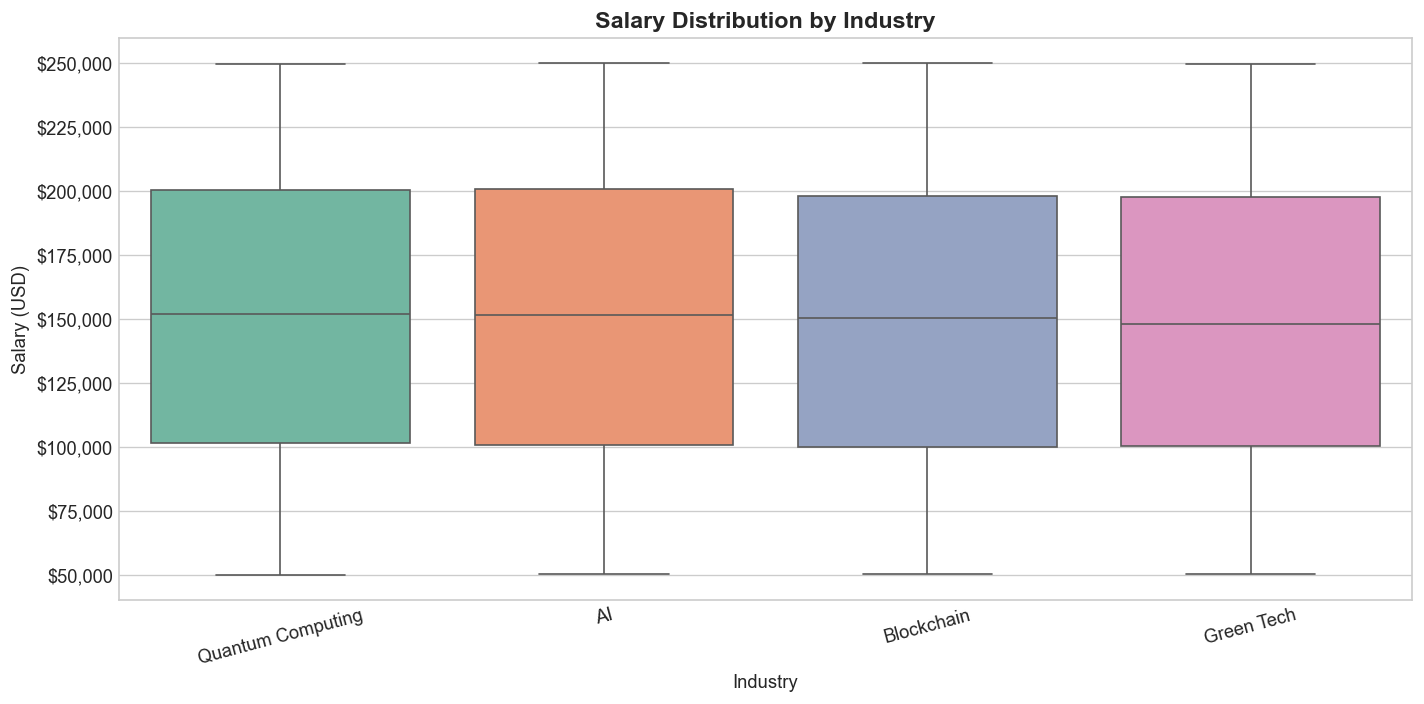

In [21]:
# 15. Salary Distribution by Industry
future_salary = df_mapping[
    (df_mapping['source'] == 'future_jobs') & 
    (df_mapping['salary'].notna()) & 
    (df_mapping['industry'] != '')
]

fig, ax = plt.subplots(figsize=(12, 6))
industry_order = future_salary.groupby('industry')['salary'].median().sort_values(ascending=False).index
sns.boxplot(data=future_salary, x='industry', y='salary', order=industry_order, ax=ax, palette='Set2')
ax.set_title('Salary Distribution by Industry', fontsize=14, fontweight='bold')
ax.set_xlabel('Industry')
ax.set_ylabel('Salary (USD)')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(FIG_DIR / '16_salary_by_industry.png', bbox_inches='tight')
plt.show()

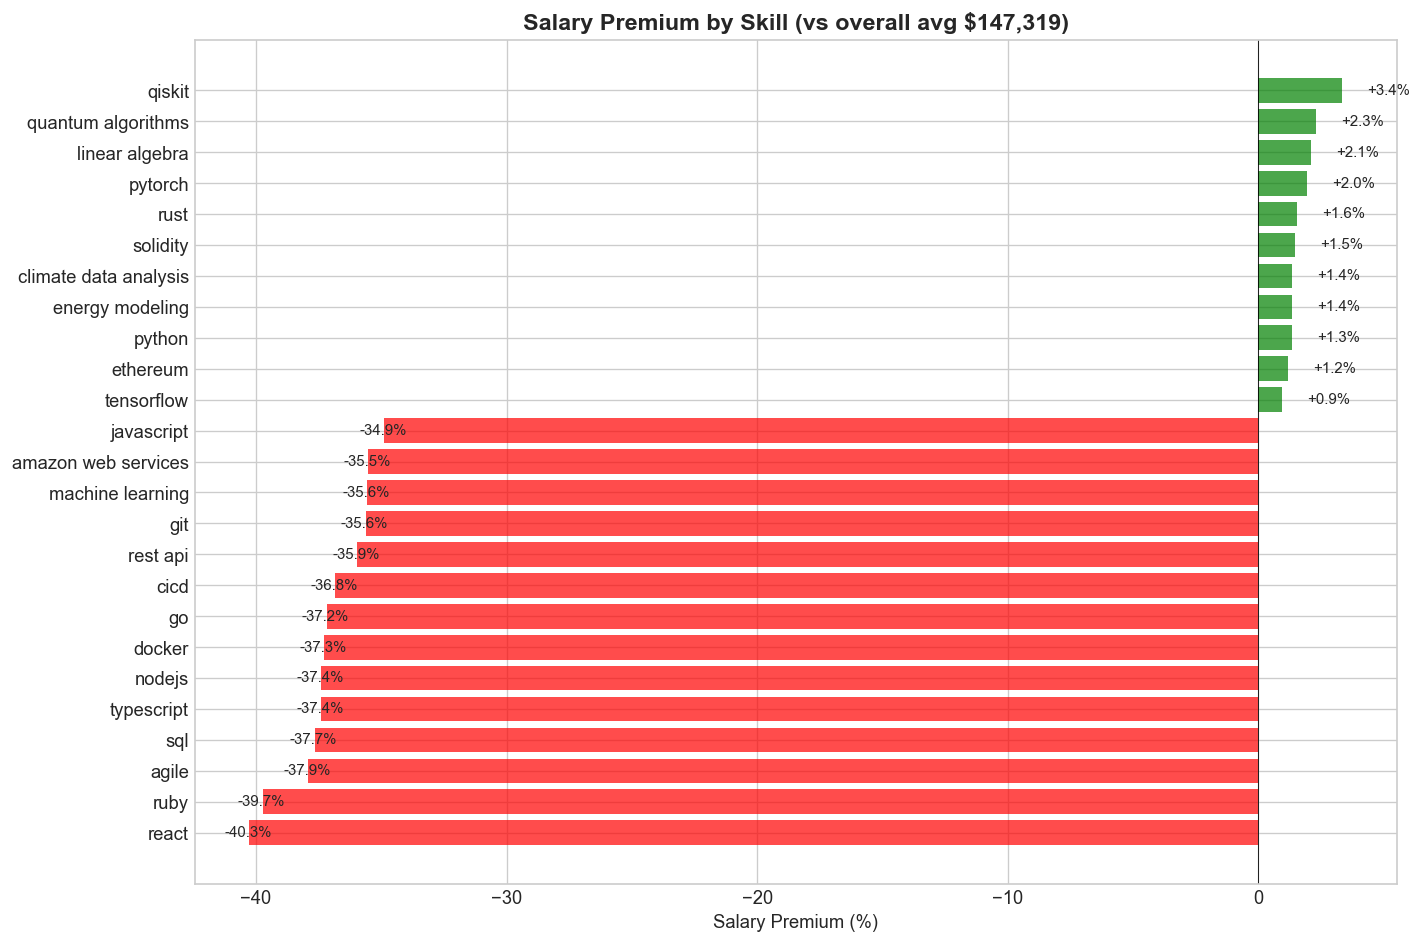

In [22]:
# 16. Salary Premium per Skill
# For each skill, compare avg salary of jobs with that skill vs overall average
overall_avg = salary_data['salary'].mean()

premium_data = []
for skill in skill_salary[skill_salary['count'] >= 10].head(25).index:
    avg = skill_salary.loc[skill, 'avg_salary']
    premium = ((avg - overall_avg) / overall_avg) * 100
    premium_data.append({'skill': skill, 'premium_pct': premium, 'avg_salary': avg})

df_premium = pd.DataFrame(premium_data).sort_values('premium_pct')

fig, ax = plt.subplots(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in df_premium['premium_pct']]
ax.barh(df_premium['skill'], df_premium['premium_pct'], color=colors, alpha=0.7)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_title(f'Salary Premium by Skill (vs overall avg ${overall_avg:,.0f})', fontsize=14, fontweight='bold')
ax.set_xlabel('Salary Premium (%)')
for i, (v, s) in enumerate(zip(df_premium['premium_pct'], df_premium['avg_salary'])):
    ax.text(v + (1 if v >= 0 else -1), i, f'{v:+.1f}%', va='center', fontsize=9)
plt.tight_layout()
plt.savefig(FIG_DIR / '17_salary_premium_by_skill.png', bbox_inches='tight')
plt.show()

## 3.8 Industry Trends

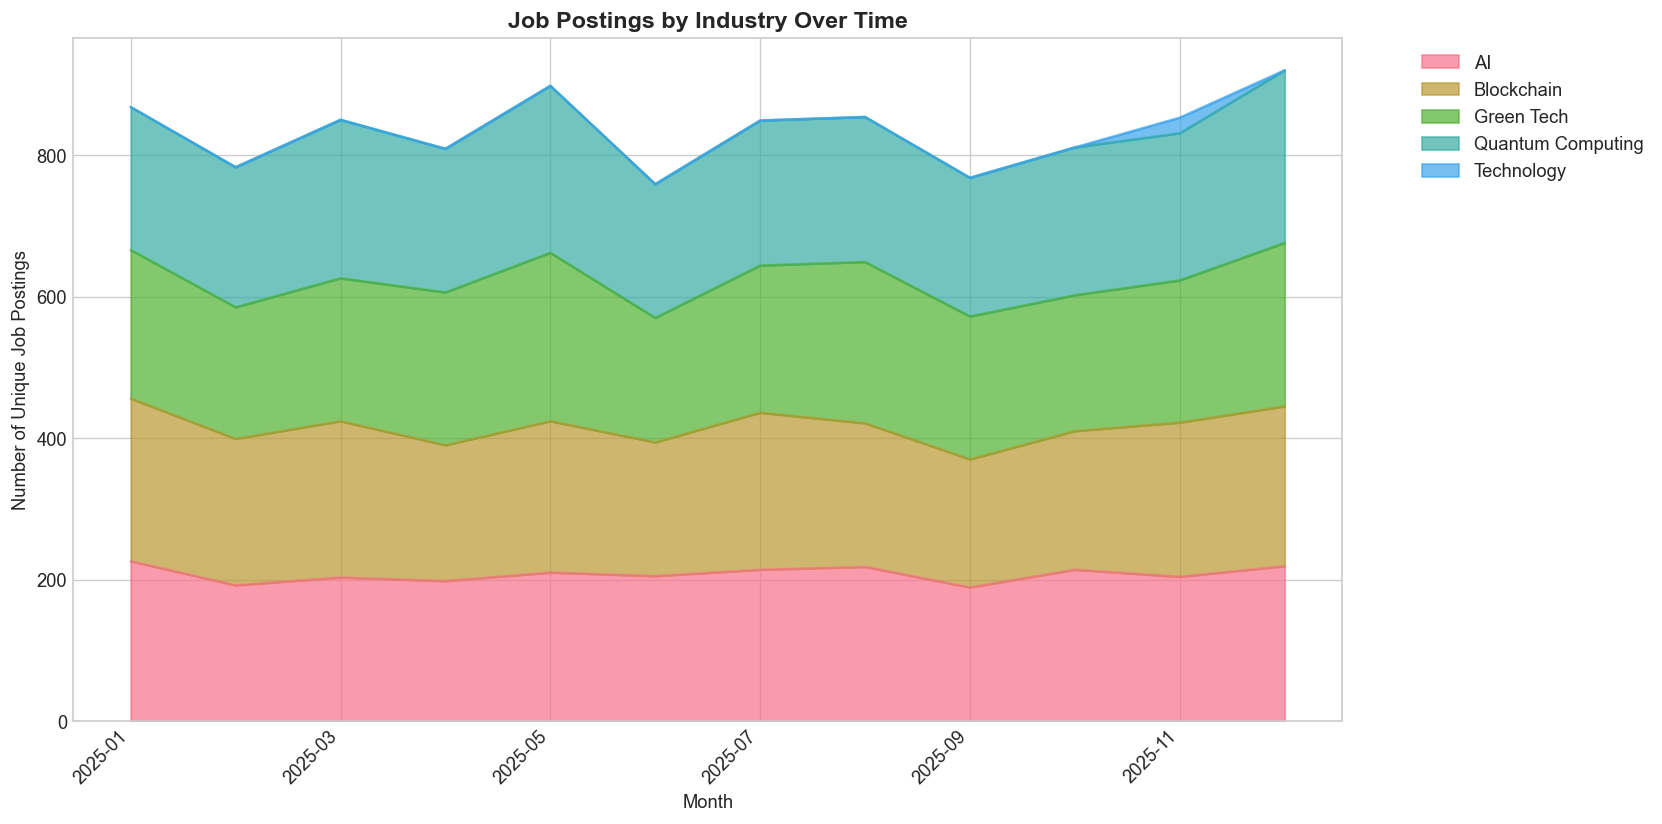

In [23]:
# 17. Job Postings by Industry Over Time
industry_temporal = df_temporal[df_temporal['industry'] != ''].copy()
if len(industry_temporal) > 0:
    industry_monthly = (
        industry_temporal
        .groupby(['month', 'industry'])
        .agg(unique_jobs=('job_id', 'nunique'))
        .reset_index()
    )
    industry_monthly['month_str'] = industry_monthly['month'].astype(str)
    
    pivot_industry = industry_monthly.pivot(index='month_str', columns='industry', values='unique_jobs').fillna(0)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    pivot_industry.plot(kind='area', ax=ax, alpha=0.7, stacked=True)
    ax.set_title('Job Postings by Industry Over Time', fontsize=14, fontweight='bold')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Unique Job Postings')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(FIG_DIR / '18_industry_postings_over_time.png', bbox_inches='tight')
    plt.show()
else:
    print('No temporal + industry data available')

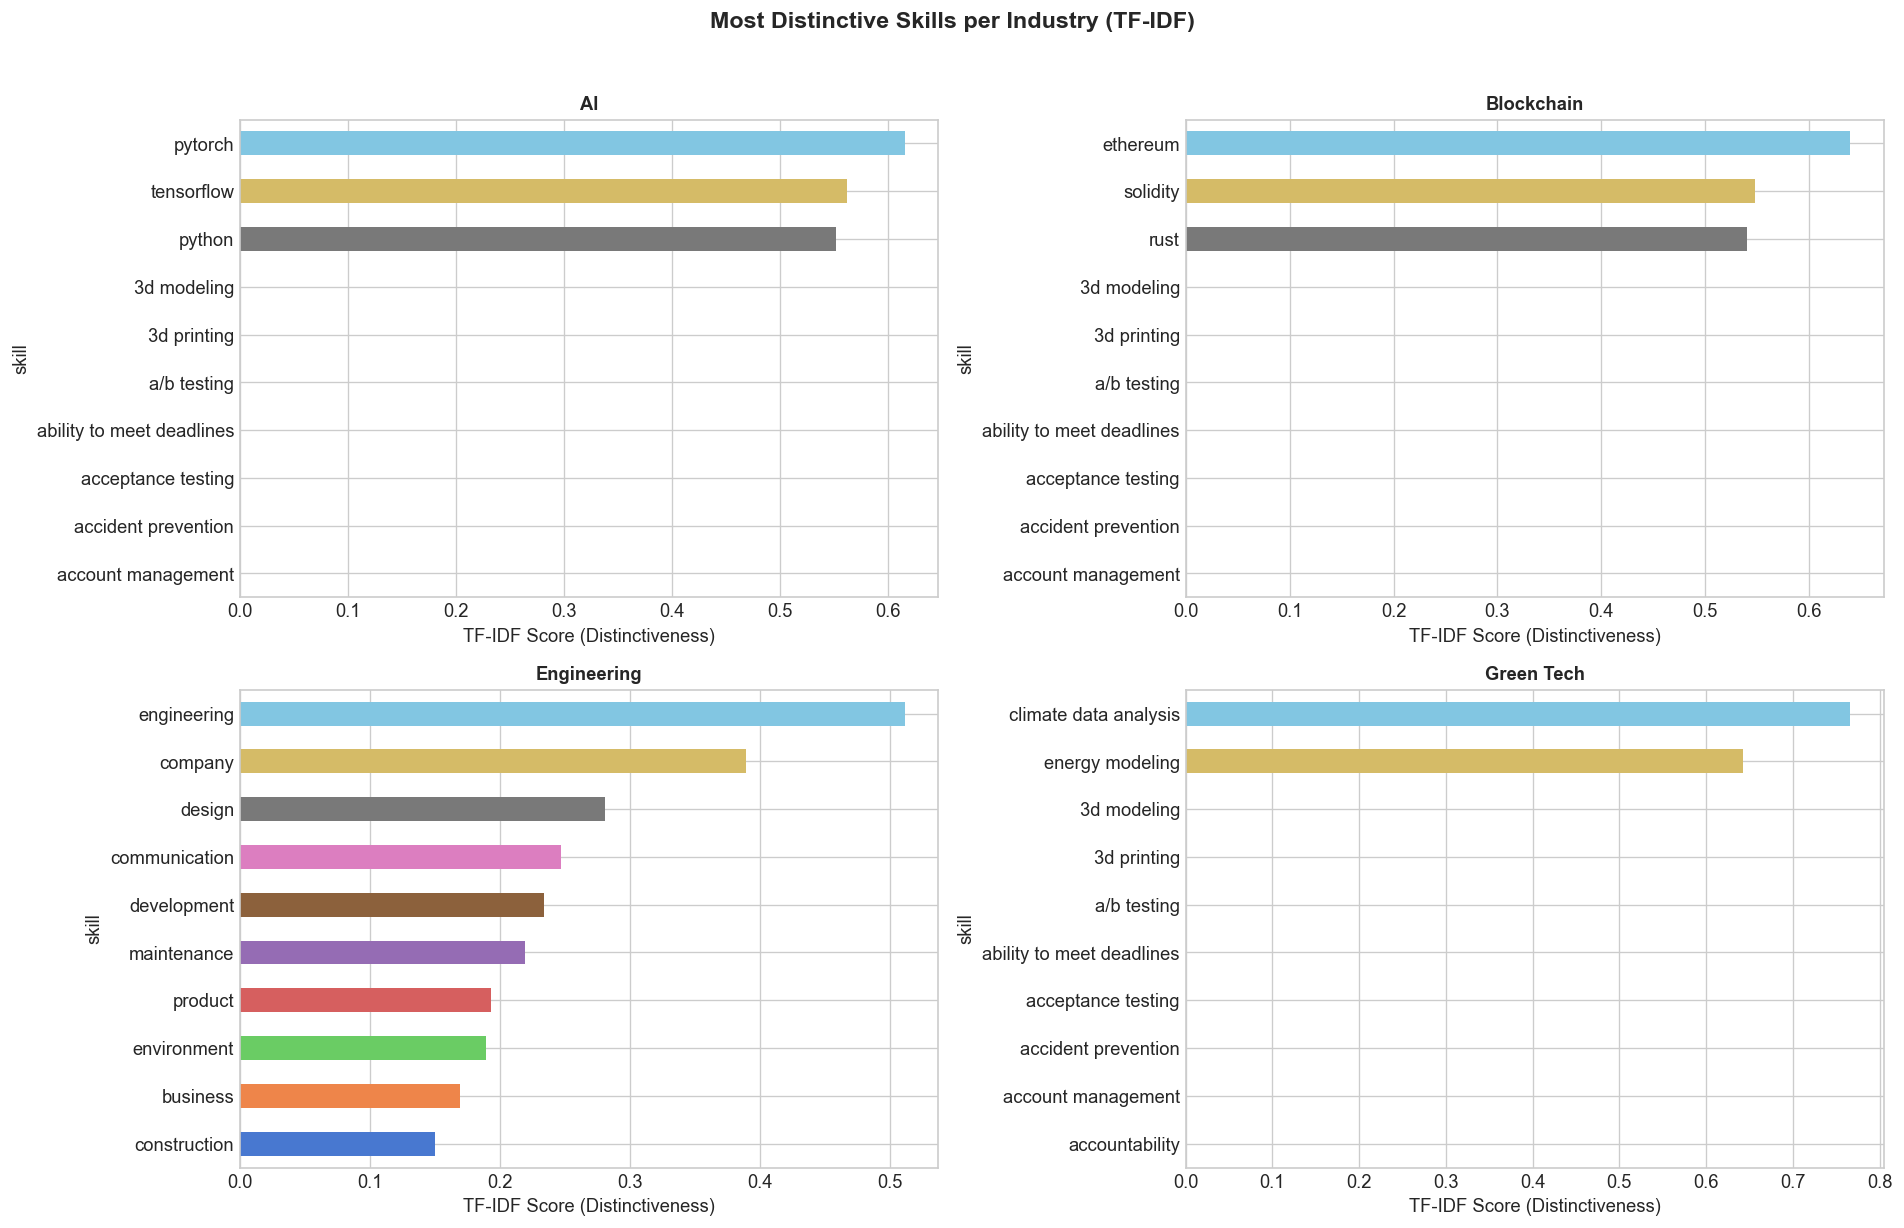

In [24]:
# 18. Industry-Specific Skills (TF-IDF weighted)
from sklearn.feature_extraction.text import TfidfTransformer

industry_data = df_mapping[df_mapping['industry'] != '']
if len(industry_data) > 0:
    # Create industry-skill count matrix
    industry_skill = industry_data.groupby(['industry', 'skill']).size().unstack(fill_value=0)
    
    # Apply TF-IDF to find distinctive skills per industry
    tfidf = TfidfTransformer()
    tfidf_matrix = tfidf.fit_transform(industry_skill)
    industry_skill_tfidf = pd.DataFrame(
        tfidf_matrix.toarray(),
        index=industry_skill.index,
        columns=industry_skill.columns
    )
    
    # Get top 10 distinctive skills per industry
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, industry in enumerate(industry_skill_tfidf.index[:4]):
        top_distinctive = industry_skill_tfidf.loc[industry].nlargest(10)
        top_distinctive.iloc[::-1].plot(kind='barh', ax=axes[idx], color=sns.color_palette('muted', 10))
        axes[idx].set_title(f'{industry}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('TF-IDF Score (Distinctiveness)')
    
    plt.suptitle('Most Distinctive Skills per Industry (TF-IDF)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(FIG_DIR / '19_industry_distinctive_skills.png', bbox_inches='tight')
    plt.show()
else:
    print('No industry data available for TF-IDF analysis')

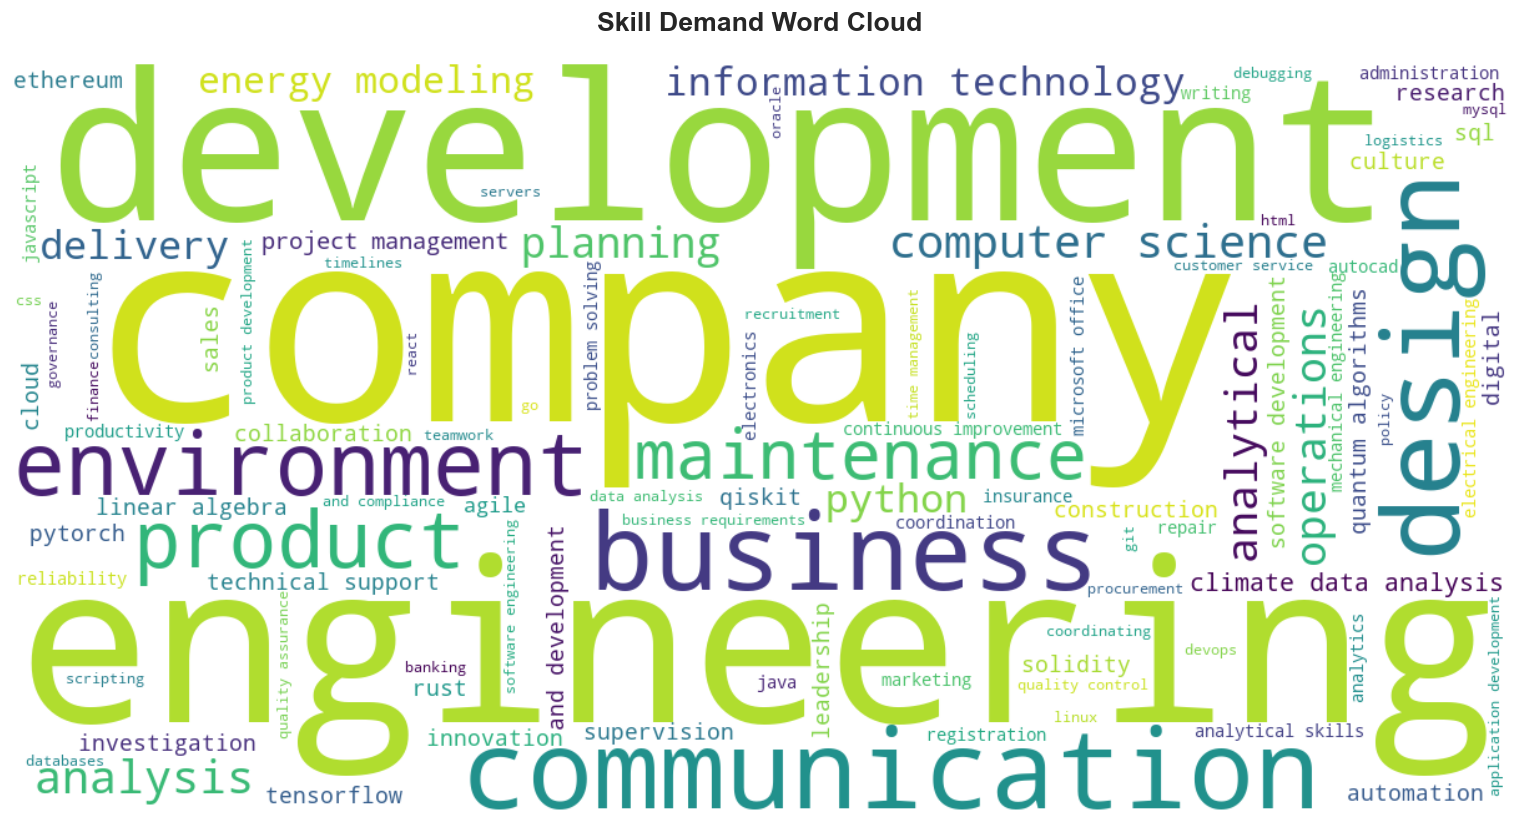

In [25]:
# Bonus: Skill Word Cloud
skill_freq = df_mapping['skill'].value_counts().to_dict()

wc = WordCloud(
    width=1200, height=600,
    background_color='white',
    colormap='viridis',
    max_words=100,
    prefer_horizontal=0.7,
)
wc.generate_from_frequencies(skill_freq)

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(wc, interpolation='bilinear')
ax.axis('off')
ax.set_title('Skill Demand Word Cloud', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(FIG_DIR / '20_skill_wordcloud.png', bbox_inches='tight')
plt.show()

## 3.9 Summary Insights

In [26]:
print('=' * 70)
print('KEY INSIGHTS FROM SKILL DEMAND ANALYSIS')
print('=' * 70)

# Top 5 most demanded skills
print('\n1. TOP 5 MOST IN-DEMAND SKILLS:')
for i, (skill, count) in enumerate(df_mapping['skill'].value_counts().head(5).items(), 1):
    print(f'   {i}. {skill} ({count:,} mentions)')

# Top 3 emerging skills (highest growth)
if len(growth_sorted) > 0:
    print('\n2. TOP 3 EMERGING SKILLS (Fastest Growing):')
    for i, (skill, rate) in enumerate(growth_sorted.head(3).items(), 1):
        print(f'   {i}. {skill} (growth: {rate:+.1f}%)')

# Most common skill combinations
print('\n3. TOP 5 SKILL COMBINATIONS:')
for i, ((s1, s2), count) in enumerate(co_occurrence.most_common(5), 1):
    print(f'   {i}. {s1} + {s2} ({count} co-occurrences)')

# Highest paying skills
if len(skill_salary_top) > 0:
    print('\n4. HIGHEST PAYING SKILLS:')
    top_paying = skill_salary[skill_salary['count'] >= 10].sort_values('avg_salary', ascending=False).head(5)
    for i, (skill, row) in enumerate(top_paying.iterrows(), 1):
        print(f'   {i}. {skill} (avg: ${row["avg_salary"]:,.0f}, n={row["count"]})')

# Dataset limitations
print('\n5. IMPORTANT CAVEATS:')
print('   - future_jobs_dataset appears synthetic (uniform distributions)')
print('   - job_market has single-date snapshot (2025-11-27), no temporal analysis')
print('   - india_jobs has no posting dates')
print('   - jobstreet skills extracted via keyword matching (may miss some)')
print('   - Temporal trends primarily from future_jobs + jobstreet dates')

KEY INSIGHTS FROM SKILL DEMAND ANALYSIS

1. TOP 5 MOST IN-DEMAND SKILLS:
   1. company (9,643 mentions)
   2. engineering (9,407 mentions)
   3. development (8,257 mentions)
   4. communication (7,882 mentions)
   5. design (7,506 mentions)

2. TOP 3 EMERGING SKILLS (Fastest Growing):
   1. python (growth: +9.0%)
   2. tensorflow (growth: +6.3%)
   3. quantum algorithms (growth: +4.4%)

3. TOP 5 SKILL COMBINATIONS:

4. HIGHEST PAYING SKILLS:
   1. qiskit (avg: $152,261, n=1682.0)
   2. quantum algorithms (avg: $150,687, n=1690.0)
   3. linear algebra (avg: $150,439, n=1666.0)
   4. pytorch (avg: $150,204, n=1637.0)
   5. rust (avg: $149,623, n=1646.0)

5. IMPORTANT CAVEATS:
   - future_jobs_dataset appears synthetic (uniform distributions)
   - job_market has single-date snapshot (2025-11-27), no temporal analysis
   - india_jobs has no posting dates
   - jobstreet skills extracted via keyword matching (may miss some)
   - Temporal trends primarily from future_jobs + jobstreet dates


In [27]:
# List all saved figures
print('\nSaved figures:')
for f in sorted(FIG_DIR.glob('*.png')):
    size_kb = f.stat().st_size / 1024
    print(f'  {f.name:50s} {size_kb:.0f} KB')


Saved figures:
  01_dataset_overview.png                            80 KB
  02_top30_skills_overall.png                        134 KB
  03_top_skills_by_industry.png                      83 KB
  04_skill_industry_heatmap.png                      101 KB
  05_skill_frequency_distribution.png                54 KB
  06_skills_per_job.png                              45 KB
  07_monthly_skill_trends.png                        282 KB
  08_skill_growth_rates.png                          60 KB
  09_emerging_skills_scatter.png                     72 KB
  10_skill_cooccurrence_heatmap.png                  175 KB
  11_skill_network_graph.png                         452 KB
  13_top_skills_by_location.png                      140 KB
  14_location_skill_heatmap.png                      126 KB
  15_salary_by_skill.png                             125 KB
  16_salary_by_industry.png                          60 KB
  17_salary_premium_by_skill.png                     111 KB
  18_industry_postings_over_tim